
#Q1)

##Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e apresentando algumas hipóteses de negócio relacionadas. Seja criativo!


Essa analise inicia COM BASE NAS CORRELAÇÕES DE VARIAVEIS NUMERICAS.
Depois eu faço uma analise relacionando os bairros e os preço.

Eu gosto de analisar os valores encontrados na correlação, correlação de pearson (padrao), spearman e o p_value.

pearson ve as relações lineares, spearmen as relações monotonicas

mas eu sempre levo em consideração que o p_value pode distorcer com datasets grandes, sendo que valores proximos de zero significa correlação significativa.


A primeira vista, olhando o P_value só para termos ideia em quem prestar atenção:

('id', 'host_id')

('id', 'numero_de_reviews')

('id', 'reviews_por_mes')

('id', 'ultima_review')

('host_id', 'reviews_por_mes')

('host_id', 'ultima_review')

('numero_de_reviews', 'reviews_por_mes')

('numero_de_reviews', 'disponibilidade_365')

('numero_de_reviews', 'ultima_review')

('reviews_por_mes', 'ultima_review')

('disponibilidade_365', 'ultima_review')


# Pela matriz de correlação:

(host_id x id) apresentam uma correlação mais significativa.

 Em seguida temos:

(numero de review x reviews por mes) e  
  
(ultima_review x reviews_por_mes)


host_id =  Representa o id do usuário que hospedou o anúncio
id – Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo

isso significa que se a pagina for baixa, o id do usuário também seria baixo !!


numero de review e reviews por mes: essa correlação indica que o numero de reviews contribui para o numero de reviews naquele mes e vice versa.

ultima_review, reviews_por_mes. Um anuncio com muitos reviews por mes acaba sendo frequentemente visitado.




em relação a correlação negativa temos o id e o numero de reviews.

quanto menor o id, maior o numero de reviews, o que significa que o id, é como se fosse o numero da pagina que esta o seu anuncio.








In [54]:
pip install shap

In [55]:
pip install sidetable

In [56]:
pip install missingno

In [57]:
pip install scipy

In [58]:
import os
import pandas as pd
import numpy as np
import sidetable as stb
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr, kendalltau
import shap
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    classification_report,
)

from sklearn.tree import plot_tree
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import joblib
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor

In [59]:
#load_dotenv(find_dotenv())
path=os.getenv("path")
path = "/content/teste_indicium_precificacao.csv"
df = pd.read_csv(path)
df.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

In [60]:
#Isso foi feito de forma que meu plot fosse aceito.
df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')

In [61]:
df.T

0      \
id                                              2595   
nome                           Skylit Midtown Castle   
host_id                                         2845   
host_name                                   Jennifer   
bairro_group                               Manhattan   
bairro                                       Midtown   
latitude                                    40.75362   
longitude                                  -73.98377   
room_type                            Entire home/apt   
price                                            225   
minimo_noites                                      1   
numero_de_reviews                                 45   
ultima_review                    2019-05-21 00:00:00   
reviews_por_mes                                 0.38   
calculado_host_listings_count                      2   
disponibilidade_365                              355   

                                                             1      \
id                                                            3647   
nome                           THE VILLAGE OF HARLEM....NEW YORK !   
host_id                                                       4632   
host_name                                                Elisabeth   
bairro_group                                             Manhattan   
bairro                                                      Harlem   
latitude                                                  40.80902   
longitude                                                 -73.9419   
room_type                                             Private room   
price                                                          150   
minimo_noites                                                    3   
numero_de_reviews                                                0   
ultima_review                                                  NaT   
reviews_por_mes                                                NaN   
calculado_host_listings_count                                    1   
disponibilidade_365                                            365   

                                                         2      \
id                                                        3831   
nome                           Cozy Entire Floor of Brownstone   
host_id                                                   4869   
host_name                                          LisaRoxanne   
bairro_group                                          Brooklyn   
bairro                                            Clinton Hill   
latitude                                              40.68514   
longitude                                            -73.95976   
room_type                                      Entire home/apt   
price                                                       89   
minimo_noites                                                1   
numero_de_reviews                                          270   
ultima_review                              2019-07-05 00:00:00   
reviews_por_mes                                           4.64   
calculado_host_listings_count                                1   
disponibilidade_365                                        194   

                                                                          3      \
id                                                                         5022   
nome                           Entire Apt: Spacious Studio/Loft by central park   
host_id                                                                    7192   
host_name                                                                 Laura   
bairro_group                                                          Manhattan   
bairro                                                              East Harlem   
latitude                                                               40.79851   
longitude                                                             -73.94399   
room_type                        

In [62]:
df.stb.missing()

missing  total    percent
ultima_review                    10052  48894  20.558760
reviews_por_mes                  10052  48894  20.558760
host_name                           21  48894   0.042950
nome                                16  48894   0.032724
id                                   0  48894   0.000000
host_id                              0  48894   0.000000
bairro_group                         0  48894   0.000000
bairro                               0  48894   0.000000
latitude                             0  48894   0.000000
longitude                            0  48894   0.000000
room_type                            0  48894   0.000000
price                                0  48894   0.000000
minimo_noites                        0  48894   0.000000
numero_de_reviews                    0  48894   0.000000
calculado_host_listings_count        0  48894   0.000000
disponibilidade_365                  0  48894   0.000000

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48878 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48873 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

<Axes: >

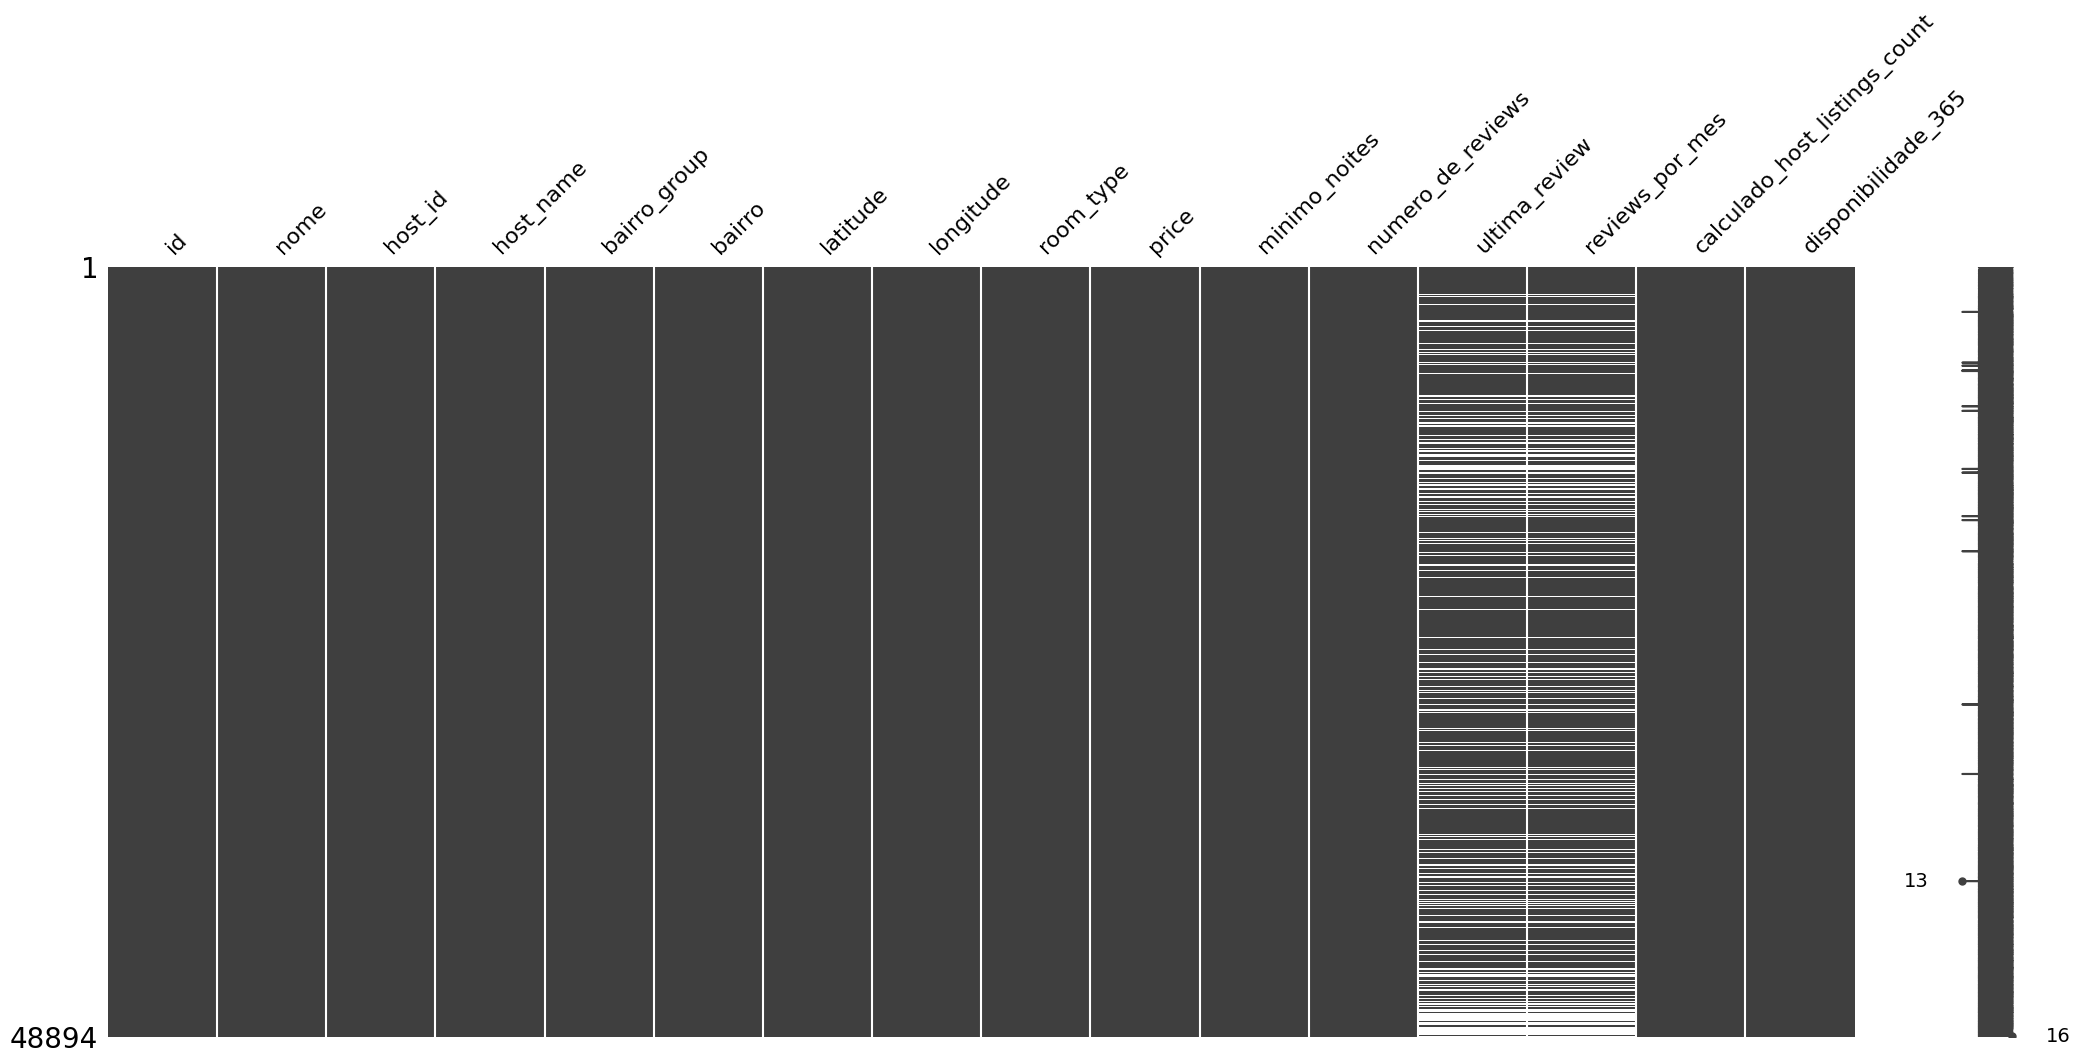

In [64]:
msno.matrix(df)

<Axes: >

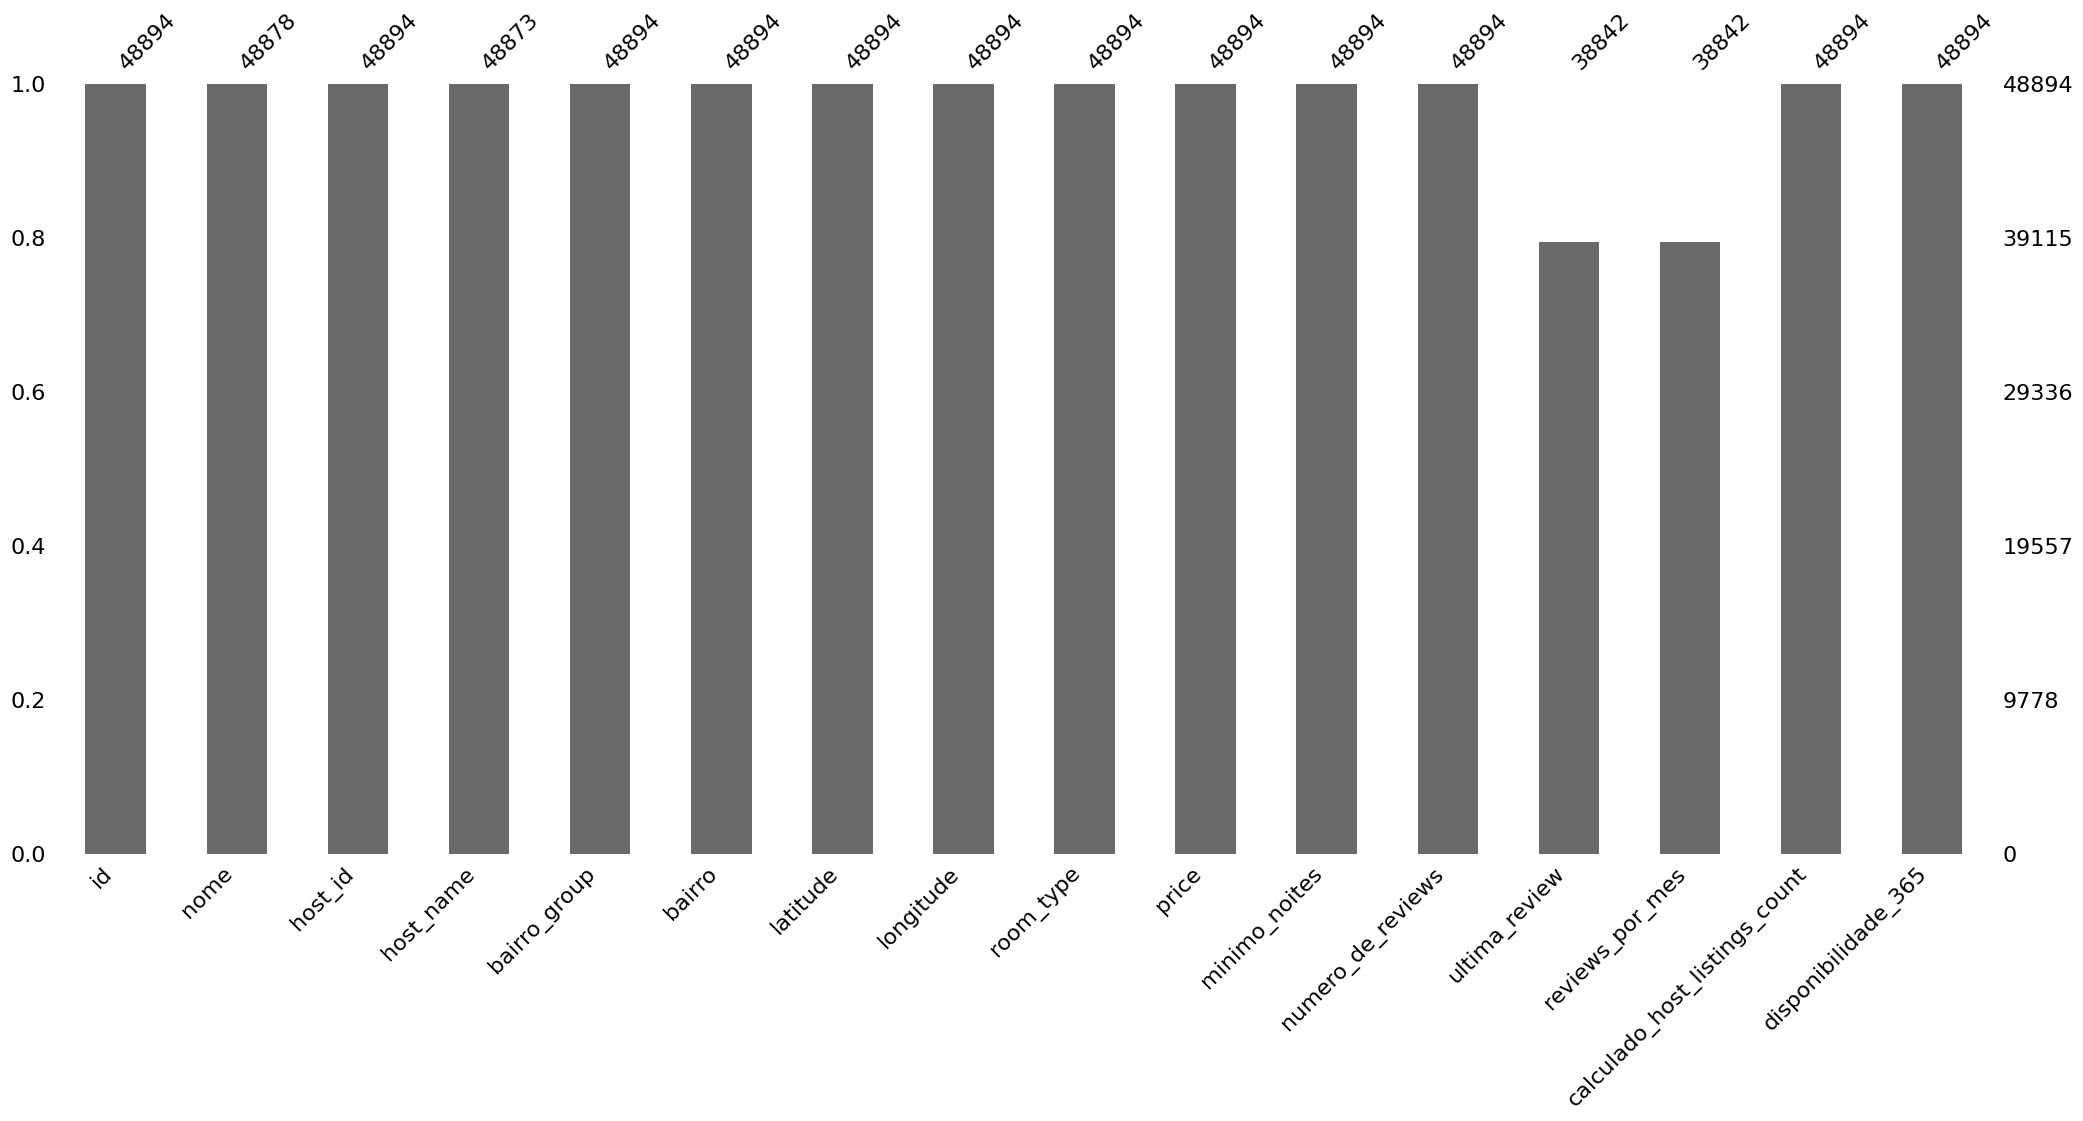

In [65]:
msno.bar(df)

In [66]:
#anuncios vazios em ultima_review e reviews_por_mes correspondem a 20%, mesmo assim eu decidi remover, pois se ele não não tem uma ultima review, ele também não terá um numero de reviews_por_mes
df = df.dropna(subset=['nome','host_name','ultima_review', 'reviews_por_mes'])
df.stb.missing()

missing  total  percent
id                                   0  38820      0.0
nome                                 0  38820      0.0
host_id                              0  38820      0.0
host_name                            0  38820      0.0
bairro_group                         0  38820      0.0
bairro                               0  38820      0.0
latitude                             0  38820      0.0
longitude                            0  38820      0.0
room_type                            0  38820      0.0
price                                0  38820      0.0
minimo_noites                        0  38820      0.0
numero_de_reviews                    0  38820      0.0
ultima_review                        0  38820      0.0
reviews_por_mes                      0  38820      0.0
calculado_host_listings_count        0  38820      0.0
disponibilidade_365                  0  38820      0.0

In [67]:
#Separando em variaveis categoricas e numericas:
cat_col = df.select_dtypes(exclude="number").columns.to_list()

if 'ultima_review' in cat_col:
    cat_col.remove('ultima_review')

print(cat_col)

['nome', 'host_name', 'bairro_group', 'bairro', 'room_type']


In [68]:
num_col=[col for col in df if col not in cat_col]
print(num_col)

['id', 'host_id', 'latitude', 'longitude', 'price', 'minimo_noites', 'numero_de_reviews', 'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']


In [69]:
df.describe()

id       host_id      latitude     longitude         price  \
count  3.882000e+04  3.882000e+04  38820.000000  38820.000000  38820.000000   
mean   1.810127e+07  6.424747e+07     40.728131    -73.951148    142.332354   
min    2.595000e+03  2.438000e+03     40.506410    -74.244420      0.000000   
25%    8.722029e+06  7.032517e+06     40.688640    -73.982462     69.000000   
50%    1.887339e+07  2.837143e+07     40.721710    -73.954805    101.000000   
75%    2.756792e+07  1.019092e+08     40.762990    -73.935020    170.000000   
max    3.645581e+07  2.738417e+08     40.913060    -73.712990  10000.000000   
std    1.069347e+07  7.589779e+07      0.054990      0.046693    196.997290   

       minimo_noites  numero_de_reviews                  ultima_review  \
count   38820.000000       38820.000000                          38820   
mean        5.869346          29.290778  2018-10-04 07:23:14.374033920   
min         1.000000           1.000000            2011-03-28 00:00:00   
25%         1.000000           3.000000            2018-07-09 00:00:00   
50%         2.000000           9.000000            2019-05-19 00:00:00   
75%         4.000000          33.000000            2019-06-23 00:00:00   
max      1250.000000         629.000000            2019-07-08 00:00:00   
std        17.389233          48.183410                            NaN   

       reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
count     38820.000000                   38820.000000         38820.000000  
mean          1.373259                       5.166589           114.879856  
min           0.010000                       1.000000             0.000000  
25%           0.190000                       1.000000             0.000000  
50%           0.720000                       1.000000            55.000000  
75%           2.020000                       2.000000           229.000000  
max          58.500000                     327.000000           365.000000  
std           1.680339                      26.303293           129.525398

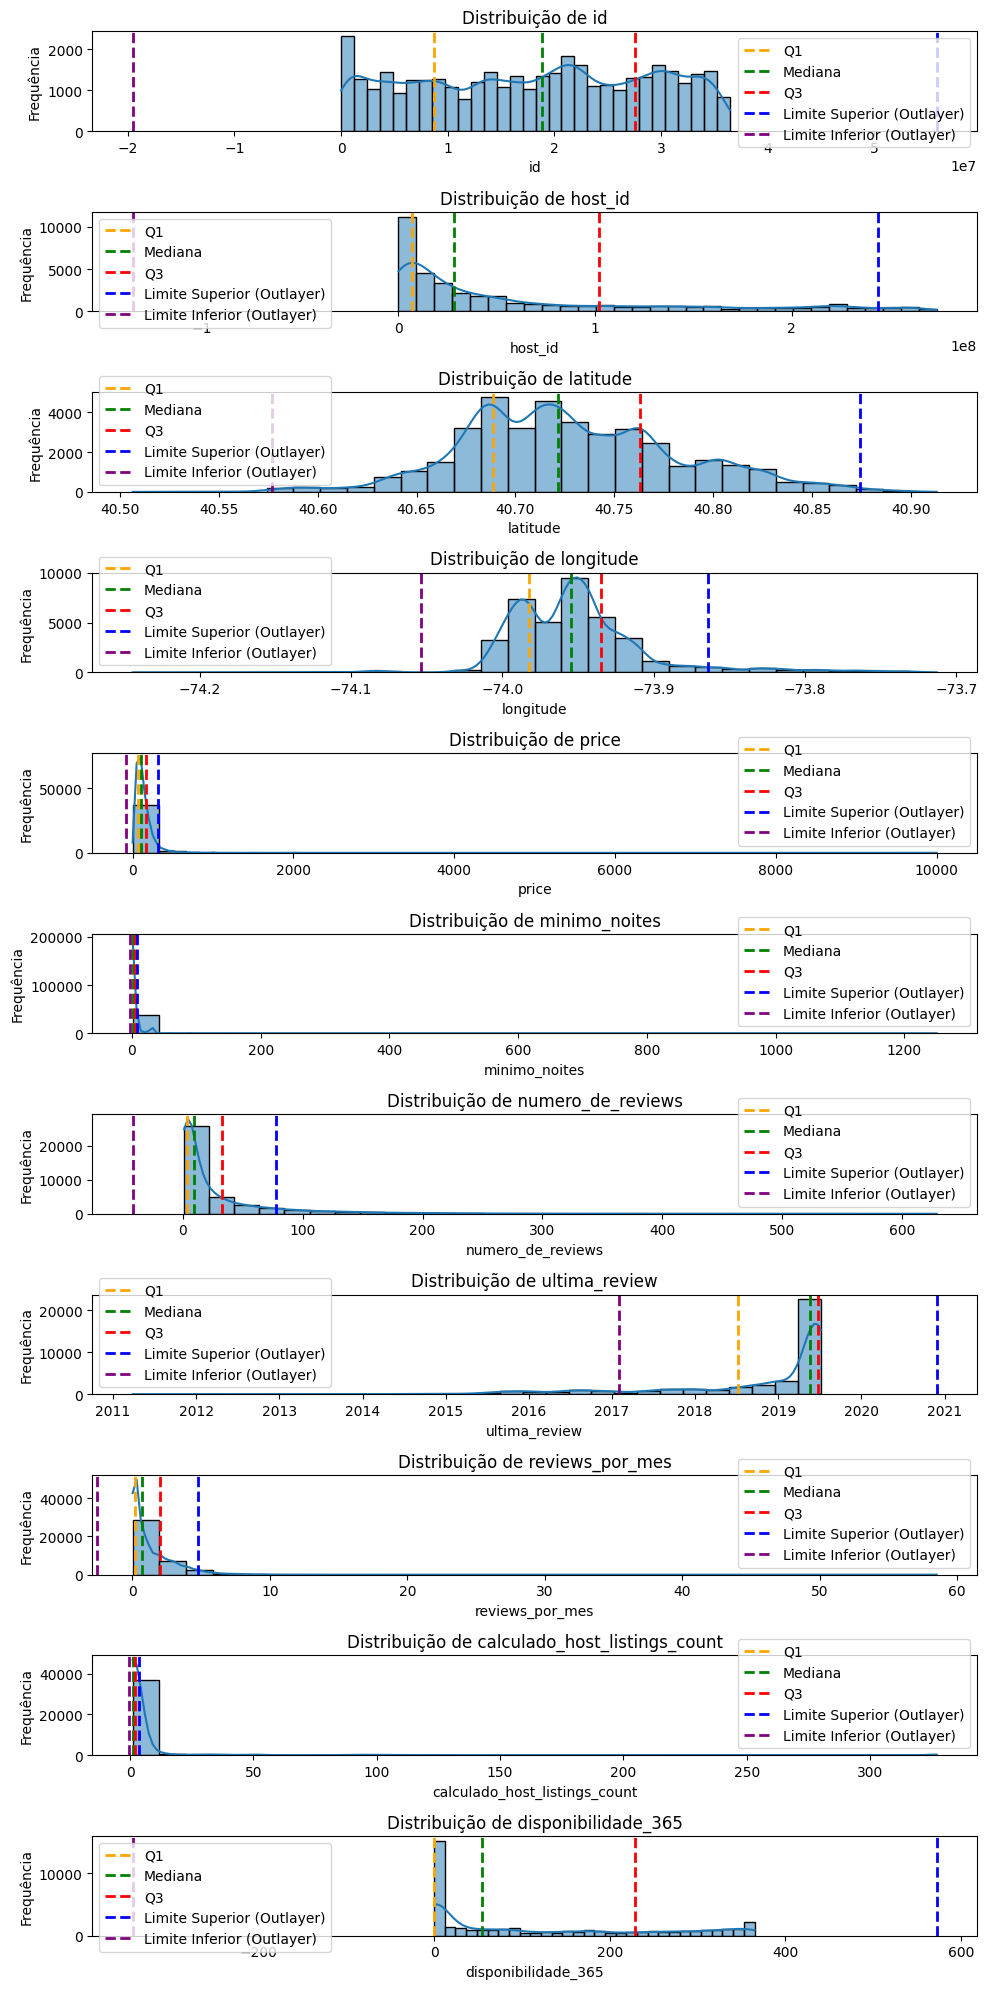

In [70]:
#EU poderia só fazer um # Distribuição das variáveis numéricas df.hist(bins=20, figsize=(14, 10)) // plt.show(), mas assim eu perderia os quantils.
numeric_cols = num_col
fig, axes = plt.subplots(nrows=len(numeric_cols), figsize=(10, 20))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # 'bins' define o número de intervalos no histograma
    # linhas verticais para os quartis
    axes[i].axvline(df[col].quantile(0.25), color='orange', linestyle='dashed', linewidth=2, label='Q1')
    axes[i].axvline(df[col].quantile(0.5), color='green', linestyle='dashed', linewidth=2, label='Mediana')
    axes[i].axvline(df[col].quantile(0.75), color='red', linestyle='dashed', linewidth=2, label='Q3')
    # intervalo interquartil (IQR)
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    upper_limit = df[col].quantile(0.75) + 1.5 * IQR
    lower_limit = df[col].quantile(0.25) - 1.5 * IQR
    # linhas verticais para os limites do IQR
    axes[i].axvline(upper_limit, color='blue', linestyle='dashed', linewidth=2, label='Limite Superior (Outlayer)')
    axes[i].axvline(lower_limit, color='purple', linestyle='dashed', linewidth=2, label='Limite Inferior (Outlayer)')

    axes[i].set_title(f'Distribuição de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].legend()
plt.tight_layout()
plt.show()


In [71]:
num_col2 = df.select_dtypes(include=['int64', 'float64', 'datetime64[ns]']).columns.tolist() #teste se o formato de datas é aceito
corr=df[num_col2].corr()

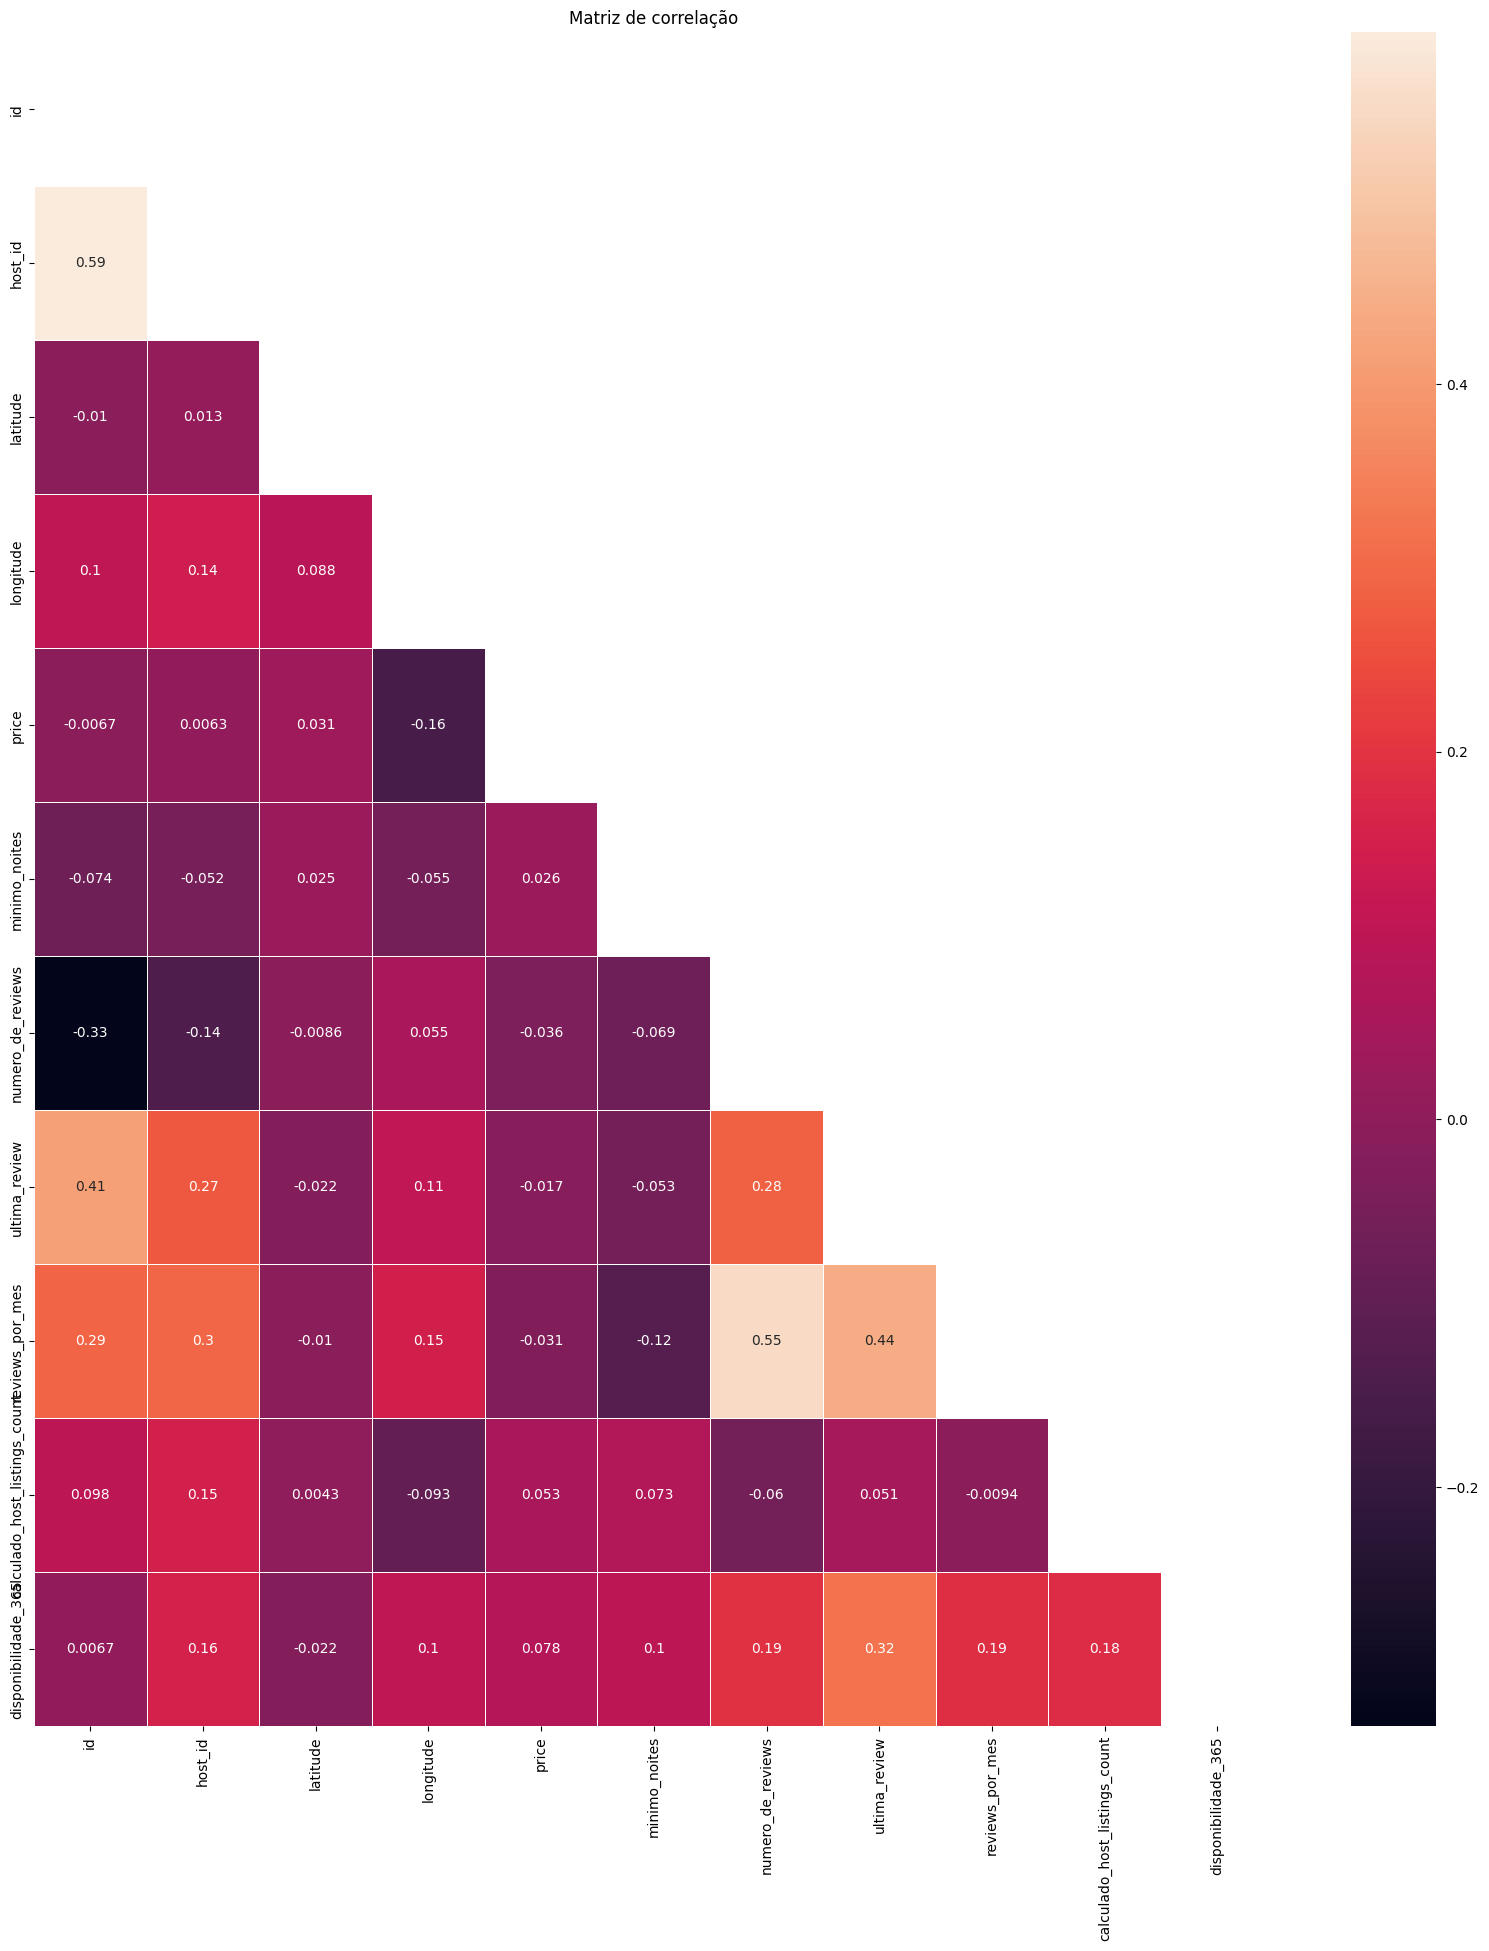

In [72]:
mask=np.triu(np.ones_like(corr))
plt.figure(figsize=(20,22))
sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5)
plt.yticks(rotation=90)
plt.title('Matriz de correlação')
plt.show()

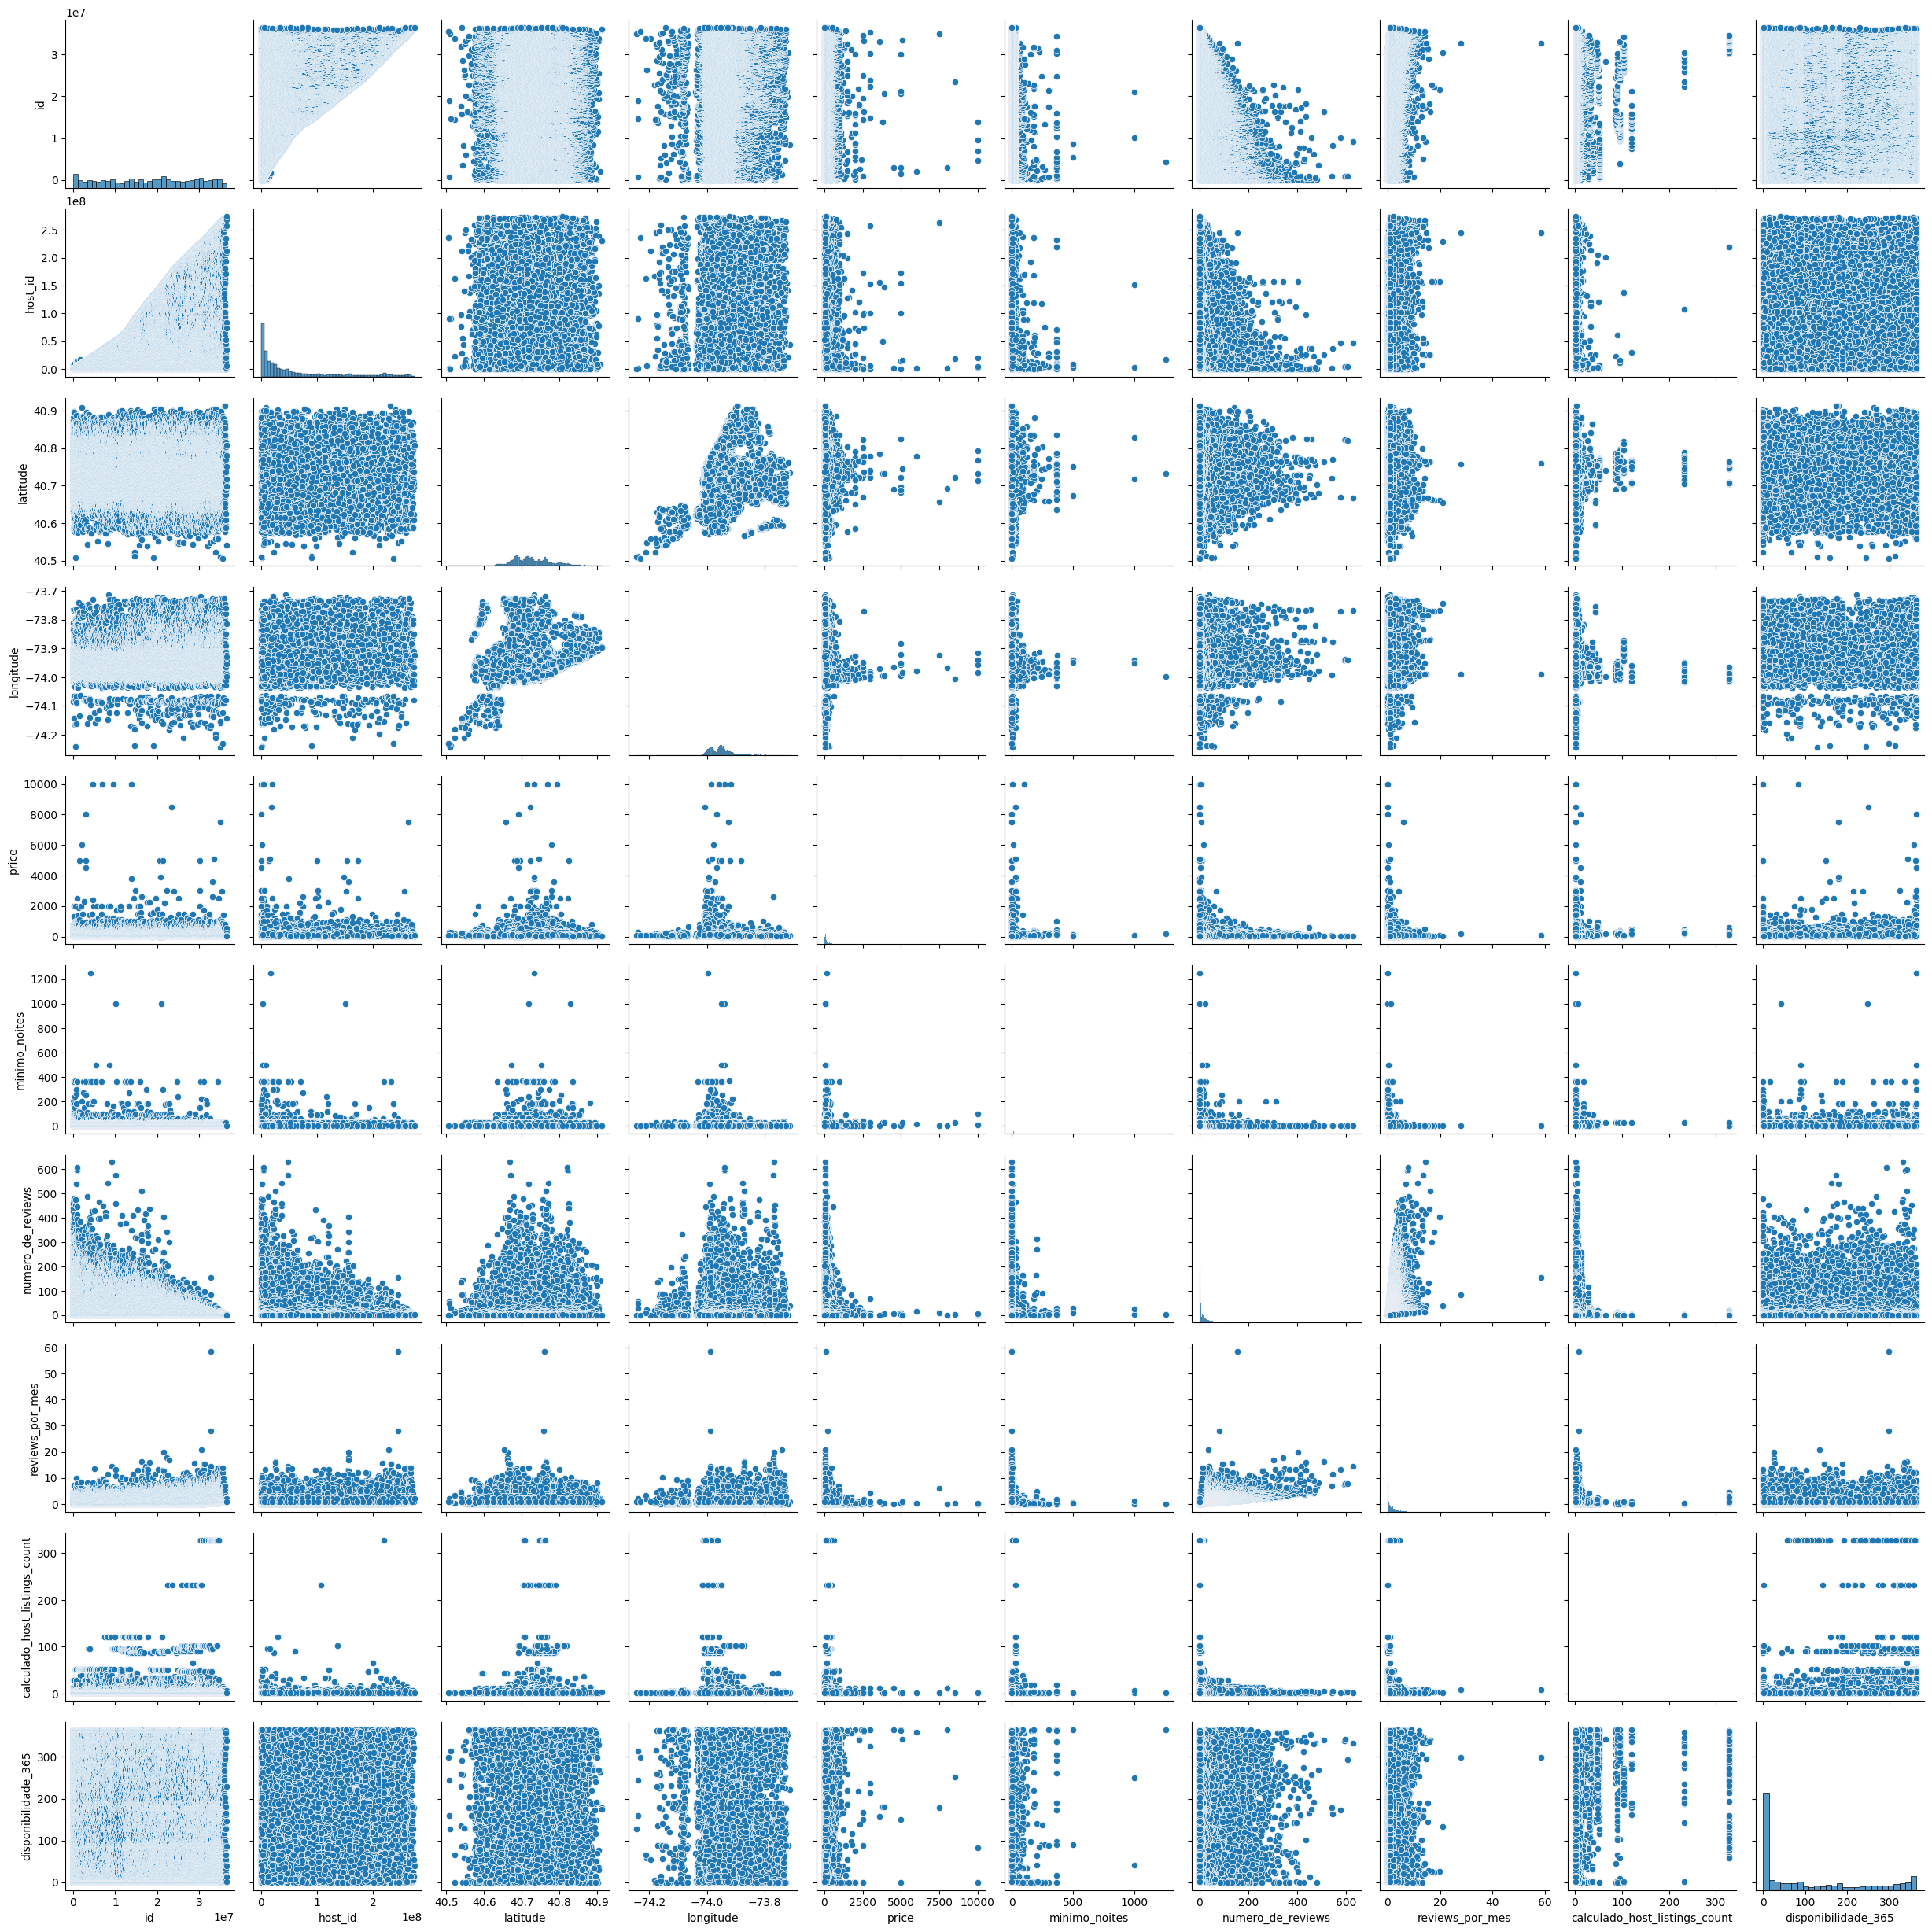

In [73]:
df_numeric = df.select_dtypes(include=['int64', 'float64']) #ele não aceita o formato em listas.. para o sns.pairplot
sns.pairplot(df_numeric)
plt.show()

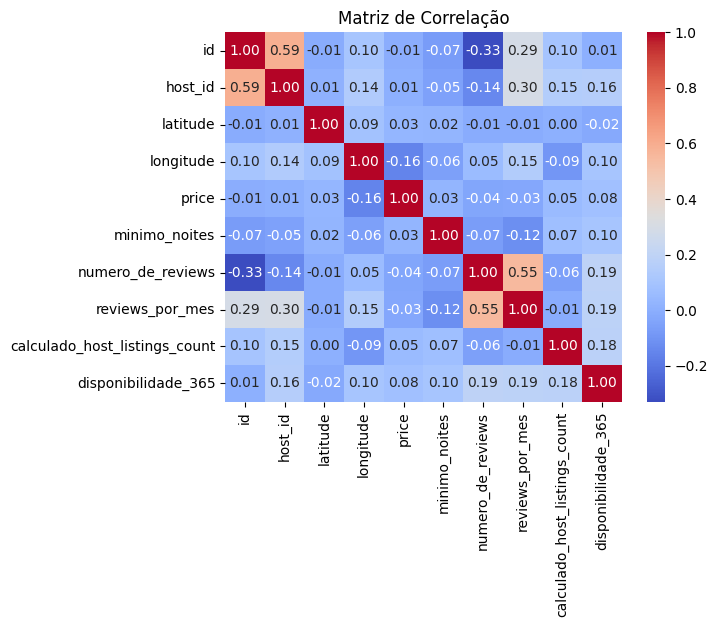

In [74]:
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

In [75]:
correlation = df['numero_de_reviews'].corr(df['reviews_por_mes'])
print(f"Correlação entre num_reviews e reviews_por_mes: {correlation}")
pearson_corr, p_value = pearsonr(df['numero_de_reviews'], df['reviews_por_mes'])
print(f"Coeficiente de correlação de Pearson: {pearson_corr}")
print(f"P-valor: {p_value}") #a correlação será forte


Correlação entre num_reviews e reviews_por_mes: 0.5496959095605823
Coeficiente de correlação de Pearson: 0.5496959095605836
P-valor: 0.0


In [76]:
#Converter colunas datetime para número de dias desde '1970-01-01'
df_datetime = df.select_dtypes(include=['datetime']).apply(lambda x: (x - pd.Timestamp("1970-01-01")).dt.days)
df_numeric = pd.concat([df.select_dtypes(include=['number']), df_datetime], axis=1)
def correlation_pvalues(df, method='pearson'):
    cols = df.columns
    p_values = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)
    zero_p_values = []

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if method == 'pearson':
                corr, p = pearsonr(df[cols[i]], df[cols[j]])
            elif method == 'spearman':
                corr, p = spearmanr(df[cols[i]], df[cols[j]])
            else:
                raise ValueError("Método inválido")

            p_values.iloc[i, j] = p
            p_values.iloc[j, i] = p


            if p == 0:
                zero_p_values.append((cols[i], cols[j]))

    return p_values, zero_p_values

p_values_matrix, zero_p_values = correlation_pvalues(df_numeric, method='pearson')
print("Matriz de P-Values:")
print(p_values_matrix)
if zero_p_values:
    print("\nPares de variáveis com p-value = 0:")
    for pair in zero_p_values:
        print(pair)
else:
    print("\nNenhuma correlação teve p-value igual a 0.")

Matriz de P-Values:
                                         id        host_id      latitude  \
id                             1.000000e+00   0.000000e+00  4.552364e-02   
host_id                        0.000000e+00   1.000000e+00  1.172353e-02   
latitude                       4.552364e-02   1.172353e-02  1.000000e+00   
longitude                      1.334817e-92  3.439855e-172  5.812082e-68   
price                          1.871533e-01   2.171661e-01  6.515559e-10   
minimo_noites                  3.245892e-48   2.225284e-24  9.422550e-07   
numero_de_reviews              0.000000e+00  6.170248e-174  9.110479e-02   
reviews_por_mes                0.000000e+00   0.000000e+00  4.565538e-02   
calculado_host_listings_count  3.259431e-84  1.285784e-192  3.923854e-01   
disponibilidade_365            1.862503e-01  2.119739e-208  1.667520e-05   
ultima_review                  0.000000e+00   0.000000e+00  1.733934e-05   

                                   longitude          price  minimo

In [77]:
df.corr(method= 'pearson', numeric_only=True)

id   host_id  latitude  longitude  \
id                             1.000000  0.591470 -0.010150   0.103321   
host_id                        0.591470  1.000000  0.012792   0.141268   
latitude                      -0.010150  0.012792  1.000000   0.088244   
longitude                      0.103321  0.141268  0.088244   1.000000   
price                         -0.006695  0.006264  0.031346  -0.155298   
minimo_noites                 -0.073952 -0.051680  0.024883  -0.055417   
numero_de_reviews             -0.330050 -0.141984 -0.008576   0.054741   
reviews_por_mes                0.291768  0.296263 -0.010144   0.146221   
calculado_host_listings_count  0.098451  0.149419  0.004341  -0.093348   
disponibilidade_365            0.006709  0.155412 -0.021849   0.102601   

                                  price  minimo_noites  numero_de_reviews  \
id                            -0.006695      -0.073952          -0.330050   
host_id                        0.006264      -0.051680          -0.141984   
latitude                       0.031346       0.024883          -0.008576   
longitude                     -0.155298      -0.055417           0.054741   
price                          1.000000       0.025501          -0.035924   
minimo_noites                  0.025501       1.000000          -0.069369   
numero_de_reviews             -0.035924      -0.069369           1.000000   
reviews_por_mes               -0.030622      -0.121718           0.549696   
calculado_host_listings_count  0.052895       0.073474          -0.059796   
disponibilidade_365            0.078278       0.101676           0.193439   

                               reviews_por_mes  calculado_host_listings_count  \
id                                    0.291768                       0.098451   
host_id                               0.296263                       0.149419   
latitude                             -0.010144                       0.004341   
longitude                             0.146221                      -0.093348   
price                                -0.030622                       0.052895   
minimo_noites                        -0.121718                       0.073474   
numero_de_reviews                     0.549696                      -0.059796   
reviews_por_mes                       1.000000                      -0.009441   
calculado_host_listings_count        -0.009441                       1.000000   
disponibilidade_365                   0.185940                       0.182988   

                               disponibilidade_365  
id                                        0.006709  
host_id                                   0.155412  
latitude                                 -0.021849  
longitude                                 0.102601  
price                                     0.078278  
minimo_noites                             0.101676  
numero_de_reviews                         0.193439  
reviews_por_mes                           0.185940  
calculado_host_listings_count             0.182988  
disponibilidade_365                       1.000000

In [78]:
df.corr(method= 'spearman', numeric_only=True)

id   host_id  latitude  longitude  \
id                             1.000000  0.565880 -0.005528   0.088450   
host_id                        0.565880  1.000000  0.038664   0.130471   
latitude                      -0.005528  0.038664  1.000000   0.041326   
longitude                      0.088450  0.130471  0.041326   1.000000   
price                         -0.050075 -0.096900  0.117930  -0.432814   
minimo_noites                 -0.155175 -0.184835  0.017371  -0.119940   
numero_de_reviews             -0.303187 -0.105265 -0.024707   0.070044   
reviews_por_mes                0.360404  0.267891 -0.023140   0.119301   
calculado_host_listings_count  0.091217  0.124561 -0.010784   0.105985   
disponibilidade_365            0.074397  0.131128 -0.021021   0.093762   

                                  price  minimo_noites  numero_de_reviews  \
id                            -0.050075      -0.155175          -0.303187   
host_id                       -0.096900      -0.184835          -0.105265   
latitude                       0.117930       0.017371          -0.024707   
longitude                     -0.432814      -0.119940           0.070044   
price                          1.000000       0.116708          -0.009507   
minimo_noites                  0.116708       1.000000          -0.168429   
numero_de_reviews             -0.009507      -0.168429           1.000000   
reviews_por_mes               -0.018644      -0.289057           0.706044   
calculado_host_listings_count -0.164168      -0.007906           0.082608   
disponibilidade_365            0.063710       0.015516           0.296300   

                               reviews_por_mes  calculado_host_listings_count  \
id                                    0.360404                       0.091217   
host_id                               0.267891                       0.124561   
latitude                             -0.023140                      -0.010784   
longitude                             0.119301                       0.105985   
price                                -0.018644                      -0.164168   
minimo_noites                        -0.289057                      -0.007906   
numero_de_reviews                     0.706044                       0.082608   
reviews_por_mes                       1.000000                       0.146131   
calculado_host_listings_count         0.146131                       1.000000   
disponibilidade_365                   0.392186                       0.369208   

                               disponibilidade_365  
id                                        0.074397  
host_id                                   0.131128  
latitude                                 -0.021021  
longitude                                 0.093762  
price                                     0.063710  
minimo_noites                             0.015516  
numero_de_reviews                         0.296300  
reviews_por_mes                           0.392186  
calculado_host_listings_count             0.369208  
disponibilidade_365                       1.000000

Variaveis categoricas agora !!!



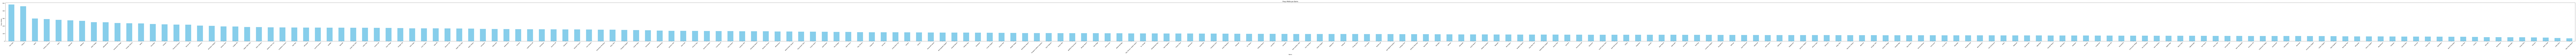

In [79]:
# agrupando por bairro e calculando o preço médio
bairro_price = df.groupby('bairro')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(400, 6))
bairro_price.plot(kind='bar', color='skyblue')
plt.title('Preço Médio por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Preço Médio')
plt.xticks(rotation=45)
plt.show()


New Dorp Beach, little neck e bull's head são os locais com a media mais barata

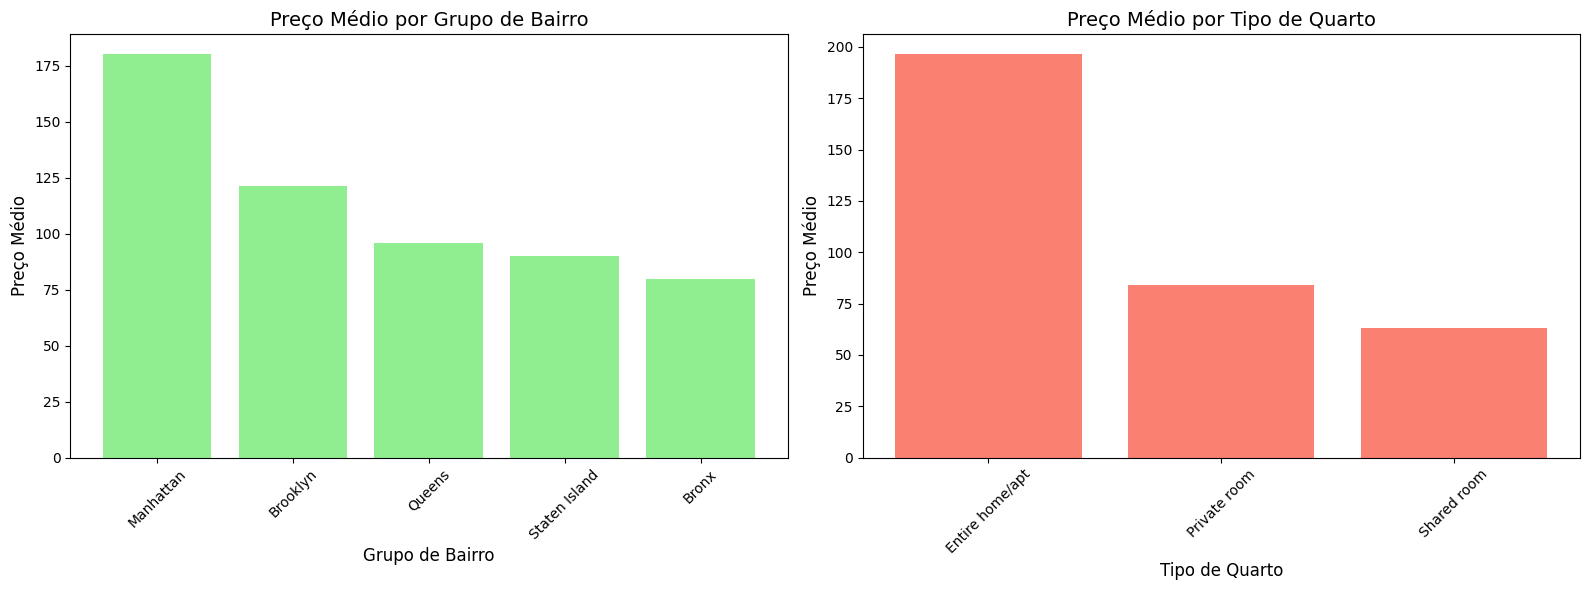

In [80]:
bairro_group_price = df.groupby('bairro_group')['price'].mean().sort_values(ascending=False)
room_price = df.groupby('room_type')['price'].mean().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1x2 grid de gráficos
axes[0].bar(bairro_group_price.index, bairro_group_price.values, color='lightgreen')
axes[0].set_title('Preço Médio por Grupo de Bairro', fontsize=14)
axes[0].set_xlabel('Grupo de Bairro', fontsize=12)
axes[0].set_ylabel('Preço Médio', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(room_price.index, room_price.values, color='salmon')
axes[1].set_title('Preço Médio por Tipo de Quarto', fontsize=14)
axes[1].set_xlabel('Tipo de Quarto', fontsize=12)
axes[1].set_ylabel('Preço Médio', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-81-6d5463a22aee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ano'] = df['ultima_review'].dt.year  # Extrair o ano


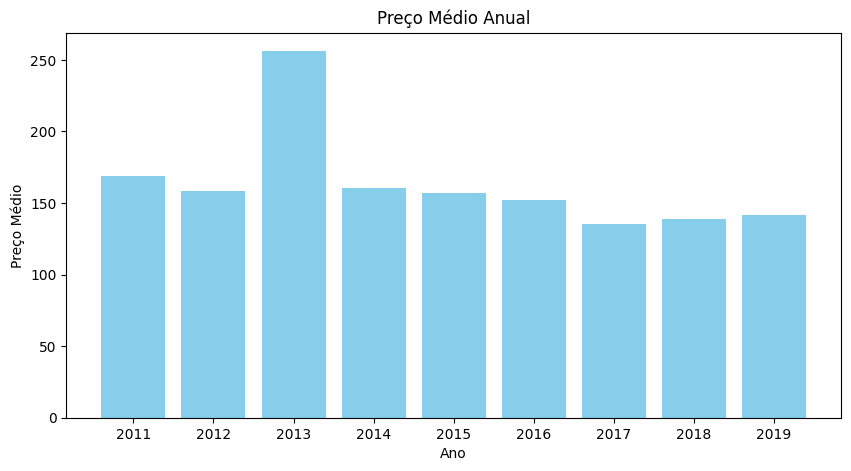

In [81]:
df['ano'] = df['ultima_review'].dt.year  # Extrair o ano
df_grouped = df.groupby('ano')['price'].mean().reset_index()  # Agrupar por ano e calcular média
plt.figure(figsize=(10, 5))
plt.bar(df_grouped['ano'], df_grouped['price'], color='skyblue')

plt.title('Preço Médio Anual')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')
plt.xticks(df_grouped['ano'])

plt.show()


## QUESTAO 2:

# A) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Existem diversos fatores que podem incidir na escolha de um apartamento. Caso a pessoa esteja interessada em um shared room, o brooklyn é o local com a media de preço mais baixa.

Caso a pessoa esteja interessada em um private room, o bronx é o local com a media de preços mais barata.

Caso a pessoa esteja interessada em um entire home/apt o bronx também é o local com a media mais barata.

Considerando que ele quer um apartamento inteiro, acredito que olhando por preço medio, o bronx é uma boa opção.

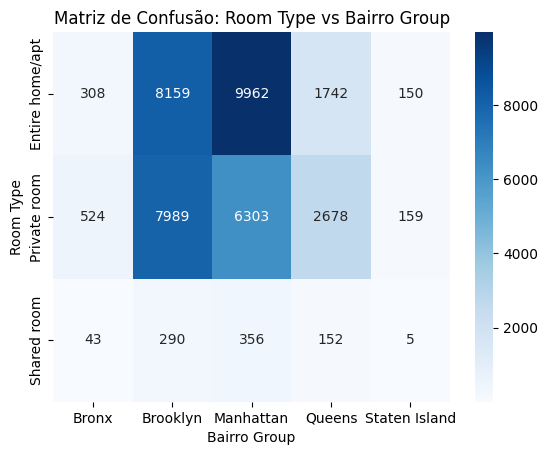

In [82]:
# SÓ QUANTIDADE !!!!! não é preço
confusion_matrix = pd.crosstab(df['room_type'], df['bairro_group'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
plt.title('Matriz de Confusão: Room Type vs Bairro Group')
plt.xlabel('Bairro Group')
plt.ylabel('Room Type')
plt.show()


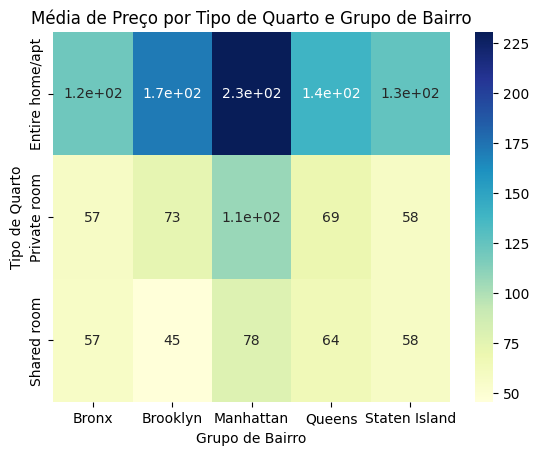

In [83]:
mean_price_by_category = df.groupby(['room_type', 'bairro_group'])['price'].mean().unstack()
sns.heatmap(mean_price_by_category, annot=True, cmap="YlGnBu")
plt.title('Média de Preço por Tipo de Quarto e Grupo de Bairro')
plt.xlabel('Grupo de Bairro')
plt.ylabel('Tipo de Quarto')
plt.show()


<ipython-input-84-b530444f6ffb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude_bin'] = pd.cut(df['latitude'], bins=20)
<ipython-input-84-b530444f6ffb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude_bin'] = pd.cut(df['longitude'], bins=20)
<ipython-input-84-b530444f6ffb>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

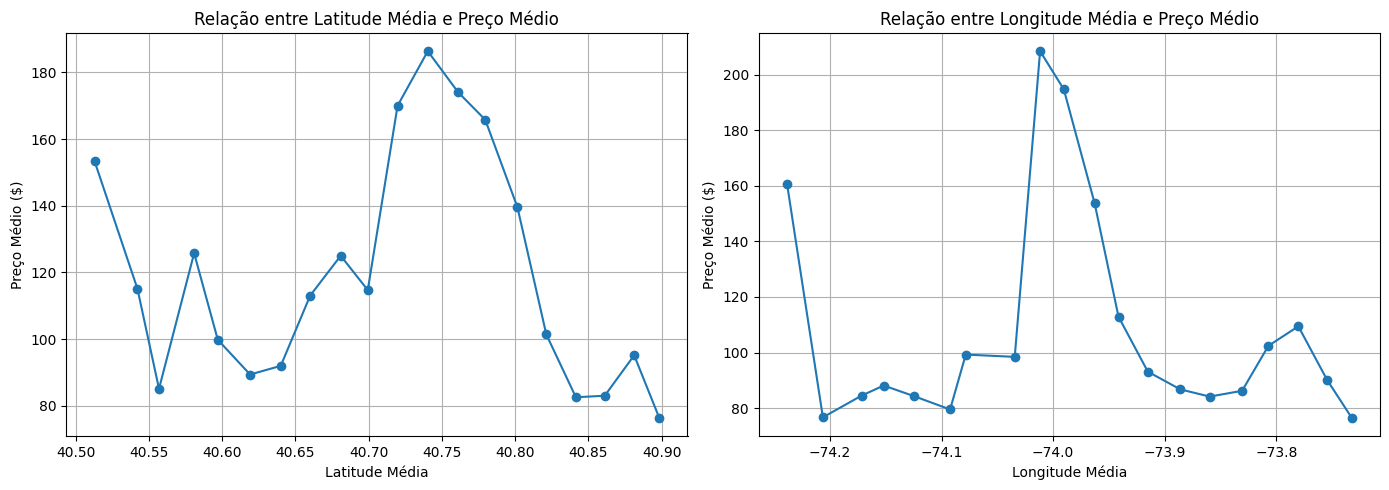

In [84]:
df['latitude_bin'] = pd.cut(df['latitude'], bins=20)
df['longitude_bin'] = pd.cut(df['longitude'], bins=20)

latitude_avg = df.groupby('latitude_bin')['latitude'].mean()
price_avg_lat = df.groupby('latitude_bin')['price'].mean()
longitude_avg = df.groupby('longitude_bin')['longitude'].mean()
price_avg_lon = df.groupby('longitude_bin')['price'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(latitude_avg, price_avg_lat, marker='o', linestyle='-')
axes[0].set_xlabel('Latitude Média')
axes[0].set_ylabel('Preço Médio ($)')
axes[0].set_title('Relação entre Latitude Média e Preço Médio')
axes[0].grid()

axes[1].plot(longitude_avg, price_avg_lon, marker='o', linestyle='-')
axes[1].set_xlabel('Longitude Média')
axes[1].set_ylabel('Preço Médio ($)')
axes[1].set_title('Relação entre Longitude Média e Preço Médio')
axes[1].grid()
plt.tight_layout()
plt.show()


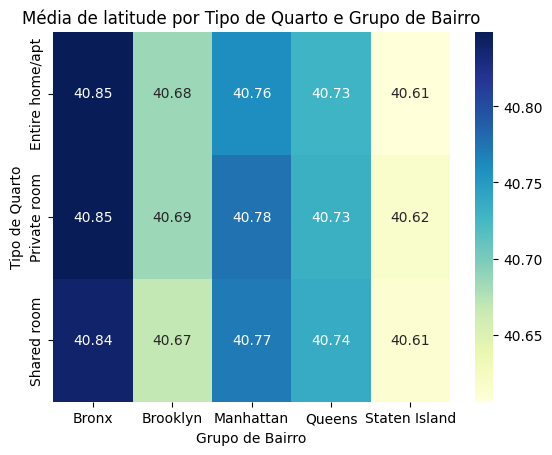

In [85]:
mean_price_by_category = df.groupby(['room_type', 'bairro_group'])['latitude'].mean().unstack()
sns.heatmap(mean_price_by_category, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Média de latitude por Tipo de Quarto e Grupo de Bairro')
plt.xlabel('Grupo de Bairro')
plt.ylabel('Tipo de Quarto')
plt.show()

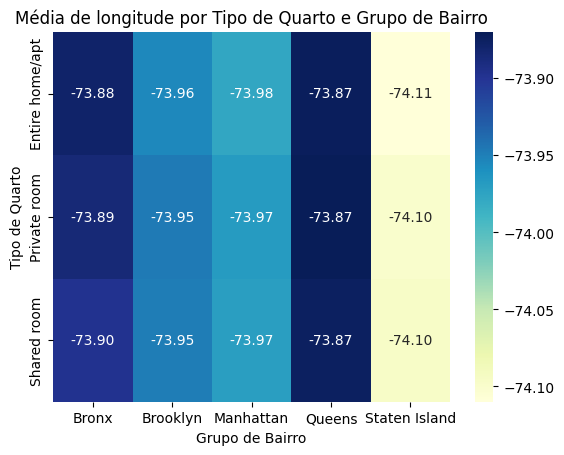

In [86]:
mean_price_by_category = df.groupby(['room_type', 'bairro_group'])['longitude'].mean().unstack()
sns.heatmap(mean_price_by_category, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Média de longitude por Tipo de Quarto e Grupo de Bairro')
plt.xlabel('Grupo de Bairro')
plt.ylabel('Tipo de Quarto')
plt.show()

##Q2)  
# B) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Bom, já temos a matriz de correlação, e olhando bem, Não há correlação entre disponnibilidade e preço, ou disponibilidade e mínimo de noites.

Assim como não há entre o mínimo de noites e o preço.


Entretanto correlação não significa causalidade.
Teoricamente, se o valor p for menor que 0.05, há uma relação estatisticamente significativa entre as variáveis, mas há um problema.


O resultado da anova mostra que a media entre o preço e o minimo de noites são muito discrepantes, por isso o resultado 0, sendo facilmente descartado como analise.

A outra relação possui valores de media próximos, e até poderia ser considerado valido, entretanto ao olhar os graficos, eu também descartaria.
O que é facil de ver, é que locações com disponibilidades muito baixas influenciam sim o preço, assim como alocações que ficam disponíveis por 1 ano inteiro também tendem a ter um preço alto.

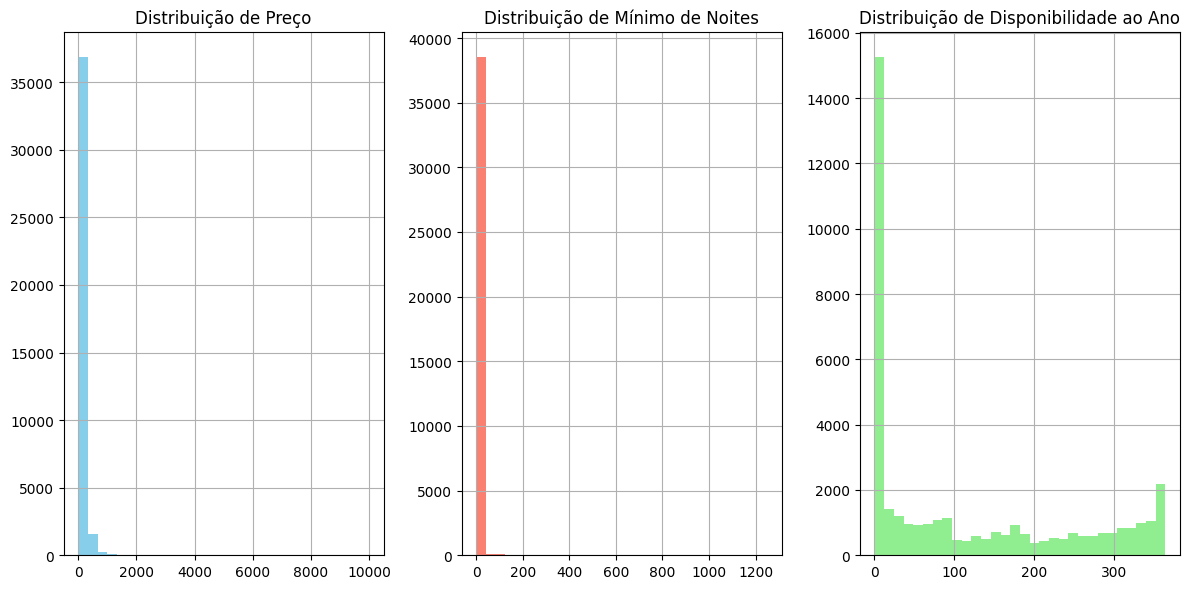

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
df['price'].hist(bins=30, color='skyblue')
plt.title('Distribuição de Preço')
plt.subplot(1, 3, 2)
df['minimo_noites'].hist(bins=30, color='salmon')
plt.title('Distribuição de Mínimo de Noites')
plt.subplot(1, 3, 3)
df['disponibilidade_365'].hist(bins=30, color='lightgreen')
plt.title('Distribuição de Disponibilidade ao Ano')
plt.tight_layout()
plt.show()


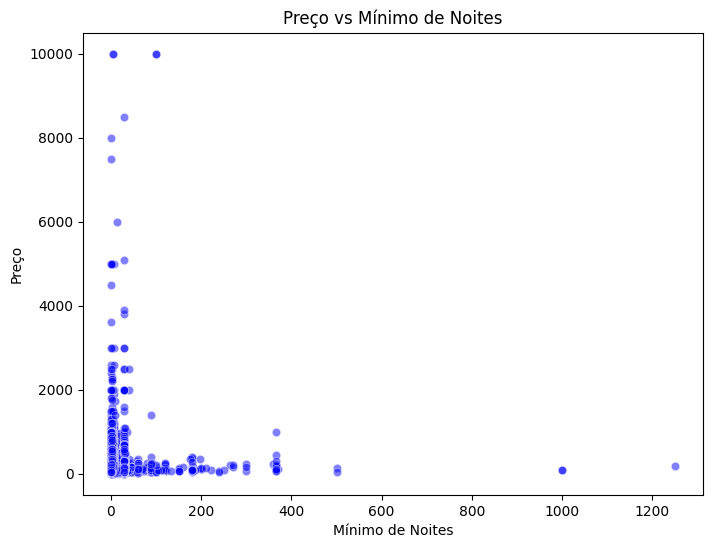

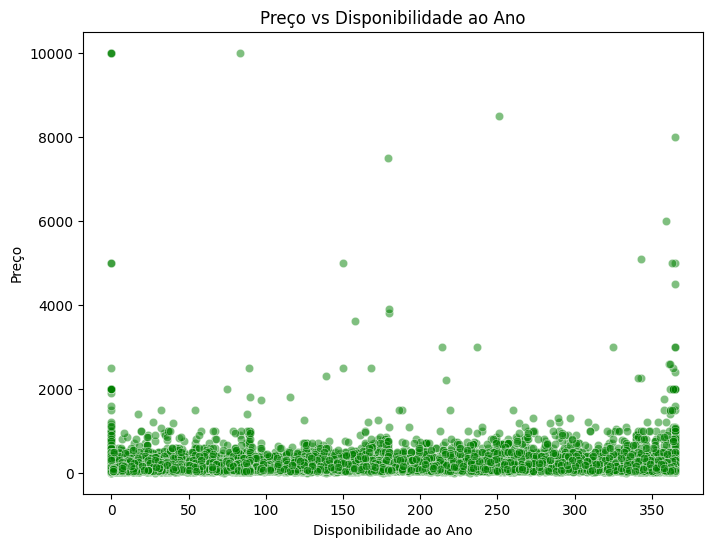

In [88]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='minimo_noites', y='price', data=df, alpha=0.5, color='blue')
plt.title('Preço vs Mínimo de Noites')
plt.xlabel('Mínimo de Noites')
plt.ylabel('Preço')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='disponibilidade_365', y='price', data=df, alpha=0.5, color='green')
plt.title('Preço vs Disponibilidade ao Ano')
plt.xlabel('Disponibilidade ao Ano')
plt.ylabel('Preço')
plt.show()


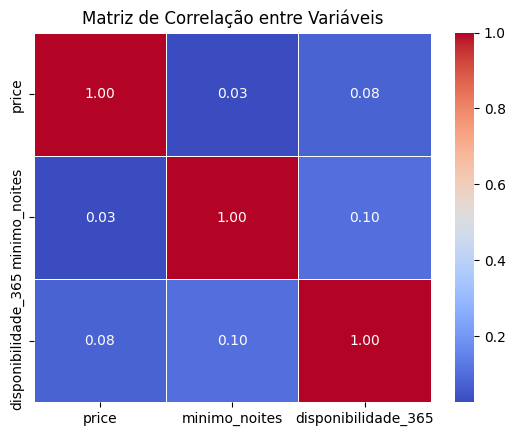

In [89]:
# apenas por formalidades
corr = df[['price', 'minimo_noites', 'disponibilidade_365']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis')
plt.show()


In [90]:
# ANOVA para ver se a média de preço varia de acordo com o número mínimo de noites
anova_minimo_noites = stats.f_oneway(*[df[df['minimo_noites'] == i]['price'] for i in df['minimo_noites'].unique()])
print(f'ANOVA para Mínimo de Noites: {anova_minimo_noites.pvalue}')

# ANOVA para ver se a média de preço varia de acordo com a disponibilidade ao ano
anova_disponibilidade = stats.f_oneway(*[df[df['disponibilidade_365'] == i]['price'] for i in df['disponibilidade_365'].unique()])
print(f'ANOVA para Disponibilidade ao Ano: {anova_disponibilidade.pvalue}')

ANOVA para Mínimo de Noites: 0.0
ANOVA para Disponibilidade ao Ano: 7.285162691491048e-17


In [91]:
'''
#Não há necessidade de usar isso !!!
import statsmodels.api as sm

# Definindo as variáveis independentes e dependentes
X = df[['minimo_noites', 'disponibilidade_365']]
y = df['price']

# Adicionando uma constante para o modelo
X = sm.add_constant(X)

# Ajustando o modelo de regressão
model = sm.OLS(y, X).fit()
print(model.summary())
'''

"\n#Não há necessidade de usar isso !!!\nimport statsmodels.api as sm\n\n# Definindo as variáveis independentes e dependentes\nX = df[['minimo_noites', 'disponibilidade_365']]\ny = df['price']\n\n# Adicionando uma constante para o modelo\nX = sm.add_constant(X)\n\n# Ajustando o modelo de regressão\nmodel = sm.OLS(y, X).fit()\nprint(model.summary())\n"

#Q2

#c) Existe algum padrão no texto do nome do local para lugares de mais alto valor?


Existem as palavras que são mais comums entre os preços medios mais altos:

[('in', 5866), ('apartment', 3255), ('bedroom', 3096), ('apt', 2456), ('studio', 2172), ('the', 1738), ('private', 1691), ('spacious', 1640), ('east', 1603), ('park', 1537), ('village', 1500), ('brooklyn', 1481), ('cozy', 1476), ('of', 1423), ('manhattan', 1325), ('with', 1231), ('to', 1230), ('loft', 1185), ('williamsburg', 1132), ('beautiful', 1085)]

E também devem haver as palavras que podem gerar valores mais altos. A questão é como isso é analisado, por isso eu fiz atravez de 2 analises.





In [92]:
high_price_listings = df[df['price'] > df['price'].median()]['nome']
words = " ".join(high_price_listings).lower()
words = re.findall(r'\b[a-zA-Z]+\b', words)
word_counts = Counter(words)
print(word_counts.most_common(20))


[('in', 5866), ('apartment', 3255), ('bedroom', 3096), ('apt', 2456), ('studio', 2172), ('the', 1738), ('private', 1691), ('spacious', 1640), ('east', 1603), ('park', 1537), ('village', 1500), ('brooklyn', 1481), ('cozy', 1476), ('of', 1423), ('manhattan', 1325), ('with', 1231), ('to', 1230), ('loft', 1185), ('williamsburg', 1132), ('beautiful', 1085)]


In [93]:
# Limitar o número de palavras e dataset
num_features = 3000
df_sample = df.sample(frac=0.2, random_state=42)
# criar TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=num_features)
X = vectorizer.fit_transform(df_sample['nome'])
feature_names = vectorizer.get_feature_names_out()
X_dense = X.toarray()
tfidf_df = pd.DataFrame(X_dense, columns=feature_names)
tfidf_df['price'] = df_sample['price'].values
correlations = tfidf_df.corr()['price'].drop('price')  # Excluir a correlação do preço com ele mesmo
top_words_high_price = correlations.sort_values(ascending=False).head(15)
print("As 15 palavras mais associadas ao preço alto: ")
print(top_words_high_price)

As 15 palavras mais associadas ao preço alto: 
unparalleled    0.147754
views           0.134021
stunning        0.127293
breathtaking    0.126280
luxury          0.115575
townhouse       0.103741
dinners         0.103590
wyndham         0.092118
reserve         0.091312
45              0.083791
gatherings      0.080767
presidential    0.078496
soho            0.075261
nolita          0.071553
ultra           0.071383
Name: price, dtype: float64


In [94]:
#USANDO BAG OF WORDS !!! que é mais leve
num_features = 10000
df_sample = df.sample(frac=0.2, random_state=42)
vectorizer = CountVectorizer(stop_words='english', max_features=num_features)
X = vectorizer.fit_transform(df_sample['nome'])
feature_names = vectorizer.get_feature_names_out()
X_dense = X.toarray()
bow_df = pd.DataFrame(X_dense, columns=feature_names)
bow_df['price'] = df_sample['price'].values
correlations = bow_df.corr()['price'].drop('price')  # excluir a correlação do preço com ele mesmo
top_words_high_price = correlations.sort_values(ascending=False).head(15)
print("As 15 palavras mais associadas ao preço alto:")
print(top_words_high_price)

As 15 palavras mais associadas ao preço alto:
unparalleled    0.147754
breathtaking    0.134594
views           0.131415
luxury          0.125994
stunning        0.122242
dinners         0.103590
townhouse       0.101106
wyndham         0.095591
reserve         0.091312
45              0.085707
presidential    0.082917
gatherings      0.078068
loft            0.076637
ultra           0.073860
soho            0.073406
Name: price, dtype: float64


##Q3

#Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


Bom, esse é um problema de regressão. E considerando que eu tenho dados categoricos, eu gosto de usar encoders e rodar algoritmos do tipo arvore.
O bom é que eles performam muito bem nessas situações, mas o lado ruim é que acabam ficando complexos em excesso. Eu tento evitar isso, rodando incialmente uma algoritmo de arvore menor, usando apenas as variaveis numericas, funciona como uma prova de conceito.

Então inicialmente eu tenho um algoritmos de arvores que apenas leva em consideração variaveis numericas. Em seguida eu tenho um algoritmo que leva em consideração as variaveis categoricas.


Um adendo é para a variavel nome que eu precisei remover, de forma a reduzir o tamanho do meu modelo. Isso inviabilizaria o modelo

Quanto as medidas de performance eu goste de usar varias:


REPORT DE MÉTRICAS DE REGRESSÃO
R2_SCORE: -1.517
MAE: 73.26
MAPE: 18550030644337.72
MSE: 83252.625

Ao que parece, utilizar os encoders tornou meu modelo pior !!!



REPORT DE MÉTRICAS DE REGRESSÃO
R2_SCORE: -1.273
MAE: 90.567
MAPE: 0.78
MSE: 74609.47

In [95]:
df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')
df['ultima_review'] = df['ultima_review'].fillna(pd.to_datetime('2010-01-01'))
df['ultima_review'] = (df['ultima_review'] - pd.to_datetime('2010-01-01')).dt.days

<ipython-input-95-39a1287b27ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')
<ipython-input-95-39a1287b27ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ultima_review'] = df['ultima_review'].fillna(pd.to_datetime('2010-01-01'))
<ipython-input-95-39a1287b27ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

## PROVA DE CONCEITO:
Ela funciona, mas resolvi deixar comentado por não ser a resposta que estamos interessados.

In [96]:
'''
features = ['id',
 'host_id',
 'latitude',
 'longitude',
 'minimo_noites',
 'numero_de_reviews',
 'ultima_review',  # Agora já numérica
 'reviews_por_mes',
 'calculado_host_listings_count',
 'disponibilidade_365']

X = df[features]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_features = features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

pipeline.fit(X_train, y_train)
'''

"\nfeatures = ['id',\n 'host_id',\n 'latitude',\n 'longitude',\n 'minimo_noites',\n 'numero_de_reviews',\n 'ultima_review',  # Agora já numérica\n 'reviews_por_mes',\n 'calculado_host_listings_count',\n 'disponibilidade_365']\n\nX = df[features]\ny = df['price']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n\nnumeric_features = features\nnumeric_transformer = Pipeline(steps=[\n    ('imputer', SimpleImputer(strategy='mean')),\n    ('scaler', StandardScaler())\n])\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', numeric_transformer, numeric_features)\n    ])\n\n\npipeline = Pipeline(steps=[\n    ('preprocessor', preprocessor),\n    ('regressor', DecisionTreeRegressor(random_state=42))\n])\n\npipeline.fit(X_train, y_train)\n"

In [97]:
'''
y_pred = pipeline.predict(X_test)
print("Pipeline:")
for step in pipeline.steps:
    print(step)
'''

'\ny_pred = pipeline.predict(X_test)\nprint("Pipeline:")\nfor step in pipeline.steps:\n    print(step)\n'

In [98]:
'''
explainer = shap.Explainer(pipeline.named_steps['regressor'])
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed, feature_names=numeric_features, plot_type="bar")
explainer = shap.Explainer(pipeline.named_steps['regressor'])
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(shap_values, X_test_transformed)
'''


'\nexplainer = shap.Explainer(pipeline.named_steps[\'regressor\'])\nX_test_transformed = pipeline.named_steps[\'preprocessor\'].transform(X_test)\nshap_values = explainer.shap_values(X_test_transformed)\nshap.summary_plot(shap_values, X_test_transformed, feature_names=numeric_features, plot_type="bar")\nexplainer = shap.Explainer(pipeline.named_steps[\'regressor\'])\nshap_values = explainer.shap_values(X_test_transformed)\nshap.summary_plot(shap_values, X_test_transformed)\n'

In [99]:
'''
feature_importances = pipeline.named_steps['regressor'].feature_importances_
importances = pd.DataFrame({'Feature': numeric_features, 'Importance': feature_importances})
importances = importances.sort_values(by='Importance', ascending=False)

print("Importância das Variáveis:")
print(importances)
'''

'\nfeature_importances = pipeline.named_steps[\'regressor\'].feature_importances_\nimportances = pd.DataFrame({\'Feature\': numeric_features, \'Importance\': feature_importances})\nimportances = importances.sort_values(by=\'Importance\', ascending=False)\n\nprint("Importância das Variáveis:")\nprint(importances)\n'

In [100]:
'''
def regression_report(y_test, y_pred):
    metrics = {
        'R2_SCORE': np.round(r2_score(y_test, y_pred), 3),
        'MAE': np.round(mean_absolute_error(y_test, y_pred), 3),
        'MAPE': np.round(mean_absolute_percentage_error(y_test, y_pred), 3),
        'MSE': np.round(mean_squared_error(y_test, y_pred), 3)
    }

    print('REPORT DE MÉTRICAS DE REGRESSÃO')
    print('R2_SCORE:', metrics['R2_SCORE'])
    print('MAE:', metrics['MAE'])
    print('MAPE:', metrics['MAPE'])
    print('MSE:', metrics['MSE'])

regression_report(y_test, y_pred)
'''

"\ndef regression_report(y_test, y_pred):\n    metrics = {\n        'R2_SCORE': np.round(r2_score(y_test, y_pred), 3),\n        'MAE': np.round(mean_absolute_error(y_test, y_pred), 3),\n        'MAPE': np.round(mean_absolute_percentage_error(y_test, y_pred), 3),\n        'MSE': np.round(mean_squared_error(y_test, y_pred), 3)\n    }\n\n    print('REPORT DE MÉTRICAS DE REGRESSÃO')\n    print('R2_SCORE:', metrics['R2_SCORE'])\n    print('MAE:', metrics['MAE'])\n    print('MAPE:', metrics['MAPE'])\n    print('MSE:', metrics['MSE'])\n\nregression_report(y_test, y_pred)\n"

In [101]:
'''
# Visualizar a árvore de decisão
plt.figure(figsize=(20,20), dpi=1350)
plot_tree(pipeline.named_steps['regressor'], feature_names=numeric_features, filled=True, rounded=True)
plt.show()
'''

"\n# Visualizar a árvore de decisão\nplt.figure(figsize=(20,20), dpi=1350)\nplot_tree(pipeline.named_steps['regressor'], feature_names=numeric_features, filled=True, rounded=True)\nplt.show()\n"

In [102]:
'''
new_price = pd.DataFrame({
    'id': [2595],
    'host_id': [2845],
    'latitude': [40.75362],
    'longitude': [-73.98377],
    'minimo_noites': [1],
    'numero_de_reviews': [45],
    'ultima_review': ['2019-05-21'],
    'reviews_por_mes': [0.38],
    'calculado_host_listings_count': [2],
    'disponibilidade_365': [355]
})

# Garantir que 'ultima_review' esteja no formato correto (número de dias desde 2010-01-01)
new_price['ultima_review'] = pd.to_datetime(new_price['ultima_review'], errors='coerce')
new_price['ultima_review'] = (new_price['ultima_review'] - pd.to_datetime('2010-01-01')).dt.days
predicted_price = pipeline.predict(new_price)
print(f"O preço previsto será de: {predicted_price[0]:.2f}")
'''

'\nnew_price = pd.DataFrame({\n    \'id\': [2595],\n    \'host_id\': [2845],\n    \'latitude\': [40.75362],\n    \'longitude\': [-73.98377],\n    \'minimo_noites\': [1],\n    \'numero_de_reviews\': [45],\n    \'ultima_review\': [\'2019-05-21\'],\n    \'reviews_por_mes\': [0.38],\n    \'calculado_host_listings_count\': [2],\n    \'disponibilidade_365\': [355]\n})\n\n# Garantir que \'ultima_review\' esteja no formato correto (número de dias desde 2010-01-01)\nnew_price[\'ultima_review\'] = pd.to_datetime(new_price[\'ultima_review\'], errors=\'coerce\')\nnew_price[\'ultima_review\'] = (new_price[\'ultima_review\'] - pd.to_datetime(\'2010-01-01\')).dt.days\npredicted_price = pipeline.predict(new_price)\nprint(f"O preço previsto será de: {predicted_price[0]:.2f}")\n'

# Q3 - SOLUÇÃO DE FATO !!

# CRIAÇÃO DO MODELO E REALIZAÇÃO DA INFERENCIA UTILIZANDO OS ENCODERS E O REGRESIONDECISION TREE

-- também não funcionou

Eu utilizei um random forest, mas que eu limitei bastante a quantidade de arvores, porque fazendo testes eu percebi que ele overfita muito facil. Então não faz diferença utilizar um modelo pequeno ou grande.

In [103]:
'''
#CONSIDERANDO O ENCODER !!!! PRECISEI TIRAR A VARIAVEL NOME DA JOGADA !!

features = ['host_name','bairro_group', 'bairro', 'room_type', 'latitude', 'longitude', 'minimo_noites',
            'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
            'calculado_host_listings_count', 'disponibilidade_365']
X = df[features]
y = df['price']

categorical_features = ['host_name', 'bairro_group', 'bairro', 'room_type']
numeric_features = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
                    'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=100), categorical_features)
    ],
    sparse_threshold=0
)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
'''

"\n#CONSIDERANDO O ENCODER !!!! PRECISEI TIRAR A VARIAVEL NOME DA JOGADA !!\n\nfeatures = ['host_name','bairro_group', 'bairro', 'room_type', 'latitude', 'longitude', 'minimo_noites',\n            'numero_de_reviews', 'ultima_review', 'reviews_por_mes',\n            'calculado_host_listings_count', 'disponibilidade_365']\nX = df[features]\ny = df['price']\n\ncategorical_features = ['host_name', 'bairro_group', 'bairro', 'room_type']\nnumeric_features = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',\n                    'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', SimpleImputer(strategy='mean'), numeric_features),\n        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=100), categorical_features)\n    ],\n    sparse_threshold=0\n)\n\n\npipeline = Pipeline(steps=[\n    ('preprocessor', preprocessor),\n    ('regressor', DecisionTreeRegres

In [104]:
'''
y_pred = pipeline.predict(X_test)
print("Pipeline:")
for step in pipeline.steps:
    print(step)
'''

'\ny_pred = pipeline.predict(X_test)\nprint("Pipeline:")\nfor step in pipeline.steps:\n    print(step)\n'

In [105]:
'''
feature_names_num = numeric_features
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
feature_names_cat = ohe.get_feature_names_out(categorical_features)
feature_names = list(feature_names_num) + list(feature_names_cat)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
'''

"\nfeature_names_num = numeric_features\nohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']\nfeature_names_cat = ohe.get_feature_names_out(categorical_features)\nfeature_names = list(feature_names_num) + list(feature_names_cat)\nX_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)\nX_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)\n"

In [106]:
'''
explainer = shap.Explainer(pipeline.named_steps['regressor'])
shap_values = explainer.shap_values(X_test_transformed_df)
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")
'''

'\nexplainer = shap.Explainer(pipeline.named_steps[\'regressor\'])\nshap_values = explainer.shap_values(X_test_transformed_df)\nshap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")\n'

In [107]:
'''
shap_values = explainer(X_test_transformed_df)
shap.plots.bar(shap_values)
'''

'\nshap_values = explainer(X_test_transformed_df)\nshap.plots.bar(shap_values)\n'

In [108]:
'''
#minhas metricas de desempenho
def regression_report(y_test, y_pred):
    metrics = {
        'R2_SCORE': np.round(r2_score(y_test, y_pred), 3),
        'MAE': np.round(mean_absolute_error(y_test, y_pred), 3),
        'MAPE': np.round(mean_absolute_percentage_error(y_test, y_pred), 3),
        'MSE': np.round(mean_squared_error(y_test, y_pred), 3)
    }

    print('REPORT DE MÉTRICAS DE REGRESSÃO')
    print('R2_SCORE:', metrics['R2_SCORE'])
    print('MAE:', metrics['MAE'])
    print('MAPE:', metrics['MAPE'])
    print('MSE:', metrics['MSE'])

regression_report(y_test, y_pred)
'''

"\n#minhas metricas de desempenho\ndef regression_report(y_test, y_pred):\n    metrics = {\n        'R2_SCORE': np.round(r2_score(y_test, y_pred), 3),\n        'MAE': np.round(mean_absolute_error(y_test, y_pred), 3),\n        'MAPE': np.round(mean_absolute_percentage_error(y_test, y_pred), 3),\n        'MSE': np.round(mean_squared_error(y_test, y_pred), 3)\n    }\n\n    print('REPORT DE MÉTRICAS DE REGRESSÃO')\n    print('R2_SCORE:', metrics['R2_SCORE'])\n    print('MAE:', metrics['MAE'])\n    print('MAPE:', metrics['MAPE'])\n    print('MSE:', metrics['MSE'])\n\nregression_report(y_test, y_pred)\n"

In [109]:
'''
# Transformando os dados de teste para SHAP
feature_names_num = numeric_features
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
feature_names_cat = ohe.get_feature_names_out(categorical_features)
feature_names = list(feature_names_num) + list(feature_names_cat)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Gerando explicações SHAP
explainer = shap.Explainer(pipeline.named_steps['regressor'])
shap_values = explainer.shap_values(X_test_transformed_df)
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")

# Exibindo os valores de SHAP
shap_values = explainer(X_test_transformed_df)
shap.plots.bar(shap_values)
'''

'\n# Transformando os dados de teste para SHAP\nfeature_names_num = numeric_features\nohe = pipeline.named_steps[\'preprocessor\'].named_transformers_[\'cat\']\nfeature_names_cat = ohe.get_feature_names_out(categorical_features)\nfeature_names = list(feature_names_num) + list(feature_names_cat)\nX_test_transformed = pipeline.named_steps[\'preprocessor\'].transform(X_test)\nX_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)\n\n# Gerando explicações SHAP\nexplainer = shap.Explainer(pipeline.named_steps[\'regressor\'])\nshap_values = explainer.shap_values(X_test_transformed_df)\nshap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar")\n\n# Exibindo os valores de SHAP\nshap_values = explainer(X_test_transformed_df)\nshap.plots.bar(shap_values)\n'

Combinação ExtraTreesRegressor e HistGradientBoostingRegressor: Acabou ficando pesado, também foi inviavel !!

In [110]:
'''
#MODELO PESADO, ACABOU NAO FUNCIONANDO.
features = ['host_name', 'bairro_group', 'bairro', 'room_type', 'latitude', 'longitude',
            'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365', 'price']
target = 'price'
numeric_features = ['latitude', 'longitude', 'minimo_noites',
                     'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365']
categorical_features = ['host_name', 'bairro_group', 'bairro', 'room_type']
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

extra_trees_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ExtraTreesRegressor(n_estimators=60, max_depth=20, random_state=42))  # Parâmetros ajustáveis
])

hist_gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(learning_rate=0.1, max_iter=50, max_depth=10, random_state=42))  # Parâmetros ajustáveis
])

extra_trees_model.fit(X_train, y_train)
y_pred_et = extra_trees_model.predict(X_test)

print("ExtraTreesRegressor Metrics:")
print("R2_SCORE:", r2_score(y_test, y_pred_et))
print("MAE:", mean_absolute_error(y_test, y_pred_et))
print("MAPE:", np.mean(np.abs((y_test - y_pred_et) / y_test)) * 100)
print("MSE:", mean_squared_error(y_test, y_pred_et))

hist_gb_model.fit(X_train, y_train)
y_pred_hgb = hist_gb_model.predict(X_test)

print("\nHistGradientBoostingRegressor Metrics:")
print("R2_SCORE:", r2_score(y_test, y_pred_hgb))
print("MAE:", mean_absolute_error(y_test, y_pred_hgb))
print("MAPE:", np.mean(np.abs((y_test - y_pred_hgb) / y_test)) * 100)
print("MSE:", mean_squared_error(y_test, y_pred_hgb))
'''


'\n#MODELO PESADO, ACABOU NAO FUNCIONANDO.\nfeatures = [\'host_name\', \'bairro_group\', \'bairro\', \'room_type\', \'latitude\', \'longitude\', \n            \'minimo_noites\', \'numero_de_reviews\', \'reviews_por_mes\', \'disponibilidade_365\', \'price\']\ntarget = \'price\'\nnumeric_features = [\'latitude\', \'longitude\', \'minimo_noites\', \n                     \'numero_de_reviews\', \'reviews_por_mes\', \'disponibilidade_365\']\ncategorical_features = [\'host_name\', \'bairro_group\', \'bairro\', \'room_type\']\nnumeric_transformer = SimpleImputer(strategy=\'median\')\ncategorical_transformer = Pipeline(steps=[\n    (\'imputer\', SimpleImputer(strategy=\'most_frequent\')),\n    (\'onehot\', OneHotEncoder(handle_unknown=\'ignore\', sparse_output=False))  \n])\n\npreprocessor = ColumnTransformer(transformers=[\n    (\'num\', numeric_transformer, numeric_features),\n    (\'cat\', categorical_transformer, categorical_features)\n])\n\nX = df[features]\ny = df[target]\nX_train, X_test

In [111]:
features = ['host_name','bairro_group', 'bairro', 'room_type', 'latitude', 'longitude', 'minimo_noites',
            'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
            'calculado_host_listings_count', 'disponibilidade_365']
X = df[features]
y = df['price']

categorical_features = ['host_name', 'bairro_group', 'bairro', 'room_type']
numeric_features = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
                    'ultima_review', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=100), categorical_features)
    ],
    sparse_threshold=0
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=55, max_depth=10, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Pipeline:")
for step in pipeline.steps:
    print(step)


Pipeline:
('preprocessor', ColumnTransformer(sparse_threshold=0,
                  transformers=[('num', SimpleImputer(),
                                 ['latitude', 'longitude', 'minimo_noites',
                                  'numero_de_reviews', 'ultima_review',
                                  'reviews_por_mes',
                                  'calculado_host_listings_count',
                                  'disponibilidade_365']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               max_categories=100),
                                 ['host_name', 'bairro_group', 'bairro',
                                  'room_type'])]))
('regressor', RandomForestRegressor(max_depth=10, n_estimators=55, random_state=42))


In [112]:
# Métricas de desempenho
def regression_report(y_test, y_pred):
    metrics = {
        'R2_SCORE': np.round(r2_score(y_test, y_pred), 3),
        'MAE': np.round(mean_absolute_error(y_test, y_pred), 3),
        'MAPE': np.round(mean_absolute_percentage_error(y_test, y_pred), 3),
        'MSE': np.round(mean_squared_error(y_test, y_pred), 3)
    }

    print('REPORT DE MÉTRICAS DE REGRESSÃO')
    print('R2_SCORE:', metrics['R2_SCORE'])
    print('MAE:', metrics['MAE'])
    print('MAPE:', metrics['MAPE'])
    print('MSE:', metrics['MSE'])

regression_report(y_test, y_pred)


REPORT DE MÉTRICAS DE REGRESSÃO
R2_SCORE: 0.126
MAE: 54.23
MAPE: 0.401
MSE: 28699.512


TESTANDO OUTRAS ESTRUTURAS:

## Q4

# Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

# Qual seria a sua sugestão de preço?

realização da inferencia !!




In [113]:
new_price = pd.DataFrame({
    'id': [2595],
    #'nome': ['Skylit Midtown Castle'],
    'host_id': [2845],
    'host_name': ['Jennifer'],
    'bairro_group': ['Manhattan'],
    'bairro': ['Midtown'],
    'latitude': [40.75362],
    'longitude': [-73.98377],
    'room_type': ['Entire home/apt'],
    'minimo_noites': [1],
    'numero_de_reviews': [45],
    'ultima_review': ['2019-05-21'],
    'reviews_por_mes': [0.38],
    'calculado_host_listings_count': [2],
    'disponibilidade_365': [35]
})

# (número de dias desde 2010-01-01)
new_price['ultima_review'] = pd.to_datetime(new_price['ultima_review'], errors='coerce')
new_price['ultima_review'] = (new_price['ultima_review'] - pd.to_datetime('2010-01-01')).dt.days
predicted_price = pipeline.predict(new_price)
print(f"O preço previsto será de: {predicted_price[0]:.2f}")

O preço previsto será de: 229.84


## Q5)

SALVANDO MEU MODELO CONFORME A



In [114]:
model_filename = 'Q5_Model_regressor_Com_categorias.pkl'
joblib.dump(pipeline, model_filename)
print(f"Modelo salvo como {model_filename}")

Modelo salvo como Q5_Model_regressor_Com_categorias.pkl


In [115]:
!pip freeze > requirements.txt

In [116]:
#pipeline = joblib.load('Q5_Model_regressor_Com_categorias.pkl')